This notebook includes analyses corresponding to the study presented in the following paper: [A Machine-learning Approach to Predict Missing Flux Densities in Multiband Galaxy Surveys
](https://iopscience.iop.org/article/10.3847/1538-4357/acacf5/meta) (Chartab et al. 2023).

### Questions
- Which wavebands are important to determine each physical parameter (e.g., photometric redshift, stellar mass)?

- Can we use optical+mid-IR data to predict near-IR flux densities?

- Is it possible to enhance the precision of SED-fitting outcomes by incorporating these predicted values?

- Could a machine learning model trained on observed galaxies outperform traditional template fitting methods?

### Dataset

I use the [COSMOS2020 catalog](https://cosmos.astro.caltech.edu/page/photom), which includes photometric data in ~40 bands from far-ultraviolet to mid-IR with broad, medium, and narrow filters, enabling precise estimations of properties such as photometric redshifts and stellar masses.

### Methods

Methods include:

- **Information Gain**: Determining the importance of photometric bands.
- **UMAP**: Visualizing multidimensional data.
- **Random Forest**: predicting missing flux densities and physical properties.
- **SED Fitting Comparison**: Assessing the impact of including predicted bands on the accuracy of SED-fitting.


In [27]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from astropy.table import Table
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors, KDTree
from matplotlib import gridspec
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import time
from matplotlib.colors import LogNorm
import warnings
import umap
from sklearn.model_selection import train_test_split
# Configure pandas display settings
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
# Configure matplotlib settings for plot aesthetics
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.dpi'] = 200
# Suppress warnings to avoid clutter
warnings.filterwarnings('ignore')

In [2]:
# Read the COSMOS2020 catalog and convert it to a pandas DataFrame
catalog_file_path = 'Data/COSMOS2020_FARMER_R1_v2.1_p3.fits'
catalog = Table.read(catalog_file_path).to_pandas()
catalog.head()

ID  ALPHA_J2000  DELTA_J2000       X_MODEL       Y_MODEL  ERRX_MODEL  \
0   1   150.477592     2.328928  14051.033584  24912.034028    0.019432   
1   2   150.477978     2.329170  14041.782916  24917.839703    0.102373   
2   3   150.477024     2.329483           NaN           NaN         NaN   
3   4   150.477312     2.330573  14057.758498  24951.520772    0.098902   
4   5   150.474793     2.332136  14118.162336  24989.006449    0.017773   

   ERRY_MODEL  ALPHA_DETECTION  DELTA_DETECTION  FARMER_ID  GROUP_ID  N_GROUP  \
0    0.011545       150.477638         2.328963  b'181_32'         1        3   
1    0.130554       150.477974         2.329169  b'181_33'         1        3   
2         NaN       150.477111         2.329667  b'181_34'         1        3   
3    0.094682       150.477316         2.330574  b'181_38'         2        1   
4    0.035394       150.474843         2.332179  b'181_39'         4        2   

   MODEL_FLAG  SOLUTION_MODEL  FLAG_HSC  FLAG_SUPCAM  FLAG_UDEEP  FLAG_UVISTA  \
0           0  b'PointSource'         0            0           0            0   
1           0  b'PointSource'         0            0           0            0   
2           2    b'ExpGalaxy'         0            0           0            0   
3           0  b'PointSource'         0            0           0            0   
4           0  b'PointSource'         0            0           0            0   

   FLAG_COMBINED    EBV_MW  CFHT_u_FLUX  CFHT_u_FLUXERR  CFHT_u_MAG  \
0              0  0.014658     0.133153        0.004186   26.089124   
1              0  0.014655     0.029307        0.004178   27.732587   
2              0  0.014679          NaN             NaN         NaN   
3              0  0.014696     0.022899        0.004130   28.000461   
4              0  0.014772     0.082093        0.004143   26.614236   

   CFHT_u_MAGERR  CFHT_u_CHISQ  CFHT_u_DRIFT  CFHT_u_VALID  CFHT_ustar_FLUX  \
0       0.033610      1.040777      0.027647          True         0.142804   
1       0.144715      0.967087      0.048660          True         0.028582   
2            NaN           NaN           NaN          True              NaN   
3       0.180041      1.068046      0.058940          True         0.032884   
4       0.053459      0.920258      0.053756          True         0.076792   

   CFHT_ustar_FLUXERR  CFHT_ustar_MAG  CFHT_ustar_MAGERR  CFHT_ustar_CHISQ  \
0            0.003567       26.013149           0.026785          0.968540   
1            0.003543       27.759766           0.126861          0.679424   
2                 NaN             NaN                NaN               NaN   
3            0.003475       27.607533           0.109061          0.809466   
4            0.003589       26.686707           0.049595          1.017402   

   CFHT_ustar_DRIFT  CFHT_ustar_VALID  HSC_g_FLUX  HSC_g_FLUXERR  HSC_g_MAG  \
0          0.034441              True    0.144235       0.003468  26.002327   
1          0.045352              True    0.040795       0.003462  27.373473   
2               NaN              True         NaN            NaN        NaN   
3          0.075417              True    0.028764       0.003296  27.752870   
4          0.066300              True    0.155039       0.003334  25.923896   

   HSC_g_MAGERR  HSC_g_CHISQ  HSC_g_DRIFT  HSC_g_VALID  HSC_r_FLUX  \
0      0.025799     0.848473     0.014467         True    0.160328   
1      0.088440     0.572034     0.131735         True    0.060943   
2           NaN          NaN          NaN         True         NaN   
3      0.117798     0.562694     0.031117         True    0.038137   
4      0.023101     0.677612     0.006032         True    0.174224   

   HSC_r_FLUXERR  HSC_r_MAG  HSC_r_MAGERR  HSC_r_CHISQ  HSC_r_DRIFT  \
0       0.004805  25.887478      0.032061     0.759969     0.006504   
1       0.004745  26.937684      0.081412     0.996346     0.077568   
2            NaN        NaN           NaN          NaN          NaN   
3       0.004580  27.446635

In [3]:
# Retrieve column names from the catalog
column_names = catalog.columns.tolist()

In [4]:
# Extract columns related to band fluxes excluding error columns
flux_columns = list(set([name for name in column_names if 'FLUX' in name]) -
                    set([name for name in column_names if 'FLUXERR' in name]))
# Extract columns related to band flux errors
flux_error_columns = [name for name in column_names if 'FLUXERR' in name]

In [5]:
# Display the flux columns for review
print(flux_columns)

['SC_IB464_FLUX', 'HSC_i_FLUX', 'SC_IB505_FLUX', 'UVISTA_Y_FLUX', 'SC_IA484_FLUX', 'SC_IB709_FLUX', 'HSC_z_FLUX', 'SC_IA679_FLUX', 'SPLASH_CH3_FLUX', 'HSC_g_FLUX', 'SC_IA527_FLUX', 'UVISTA_J_FLUX', 'HSC_y_FLUX', 'SC_IA767_FLUX', 'UVISTA_H_FLUX', 'SPLASH_CH4_FLUX', 'HSC_r_FLUX', 'IRAC_CH4_FLUX', 'SC_IA738_FLUX', 'IRAC_CH2_FLUX', 'UVISTA_Ks_FLUX', 'SPLASH_CH1_FLUX', 'ACS_F814W_FLUX', 'SC_IB427_FLUX', 'GALEX_NUV_FLUX', 'SC_IA624_FLUX', 'CFHT_ustar_FLUX', 'UVISTA_NB118_FLUX', 'IRAC_CH3_FLUX', 'GALEX_FUV_FLUX', 'SC_IB574_FLUX', 'SC_NB711_FLUX', 'SC_NB816_FLUX', 'SC_IB827_FLUX', 'CFHT_u_FLUX', 'IRAC_CH1_FLUX', 'SPLASH_CH2_FLUX']


I use two sets of wavebands: (1) H20-like bands: A :={u, g, r, i, z, ch1, and ch2} and (2) H20+UVISTA (Euclid)-like bands: B :={u, g, r, i, z, Y, J, H, ch1, and ch2}. So I only keep u, g, r, i, z, Y, J, H, ch1, and ch2 bands.

In [6]:
selected_flux_columns = [
    'CFHT_u_FLUX', 'HSC_g_FLUX', 'HSC_r_FLUX', 'HSC_i_FLUX', 
    'HSC_z_FLUX', 'UVISTA_Y_FLUX', 'UVISTA_J_FLUX', 
    'UVISTA_H_FLUX', 'IRAC_CH1_FLUX', 'IRAC_CH2_FLUX']
selected_flux_error_columns = [
    'CFHT_u_FLUXERR', 'HSC_g_FLUXERR', 'HSC_r_FLUXERR', 'HSC_i_FLUXERR', 
    'HSC_z_FLUXERR', 'UVISTA_Y_FLUXERR', 'UVISTA_J_FLUXERR', 
    'UVISTA_H_FLUXERR', 'IRAC_CH1_FLUXERR', 'IRAC_CH2_FLUXERR']

Photometric measurements in the COSMOS2020 catalog are not corrected for Galactic extinction. I correct them using the Schlafly and Finkbeiner (2011) dust map in the following.

In [7]:
# Define the names of the photometric filters and their corresponding A_lambda/E(B-V) values
filter_names = [
    'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 
    'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'IRAC_CH1', 'IRAC_CH2']
extinction_values = [4.807, 3.69, 2.715, 2.0, 1.515, 1.213, 0.874, 0.565, 0.163, 0.112]

In [8]:
# Create a dictionary to map each filter name to its A_lambda/E(B-V) value
extinction_correction_factors = {filter_names[i]: extinction_values[i] for i in range(len(filter_names))}

In [9]:
# Apply the extinction correction to the flux columns in the catalog
for flux_column in selected_flux_columns:
    filter_name = flux_column[:-5]  # Extract the filter name from the flux column name
    correction_factor = 10**(0.4 * extinction_correction_factors[filter_name] * catalog['EBV_MW'])
    catalog[flux_column] = catalog[flux_column] * correction_factor

In [10]:
# Apply the extinction correction to the flux error columns in the catalog
for flux_error_column in selected_flux_error_columns:
    filter_name = flux_error_column[:-8]  # Extract the filter name from the flux error column name
    correction_factor = 10**(0.4 * extinction_correction_factors[filter_name] * catalog['EBV_MW'])
    catalog[flux_error_column] = catalog[flux_error_column] * correction_factor

I select subset of galaxies observed in all bands, with i-band AB magnitude $\leq$25 and 3$\sigma$ detection.

In [11]:
# Calculate the signal-to-noise ratio for each flux column and add as new columns to the catalog
for i, flux_column in enumerate(selected_flux_columns):
    signal_to_noise_column = flux_column + '_SN'
    catalog[signal_to_noise_column] = catalog[flux_column] / catalog[selected_flux_error_columns[i]]

In [12]:
# Filter the catalog to include only entries with HSC_i magnitude less than or equal to 25 (S/N>=3)
# and not equal to -99 (indicate a missing value)
catalog_i = catalog[(catalog['HSC_i_MAG'] <= 25) & (catalog['HSC_i_FLUX_SN'] >= 3)
                                        & (catalog['HSC_i_MAG'] != -99)]

Let's remove stars and unobserved data in all required bands.

In [13]:
catalog_i_gal = catalog_i[(catalog_i.lp_type == 0)&(catalog_i.FLAG_HSC==0)&(catalog_i.FLAG_UVISTA==0)]

In [14]:
# Initialize a 'detect' column to True, which will be used to mark detections across all bands
catalog_i_gal['detect'] = True
# Check for NaN values across all flux columns and update 'detect' column accordingly
for flux_column in selected_flux_columns:
    catalog_i_gal['detect'] &= ~np.isnan(catalog_i_gal[flux_column])

In [15]:
# Filter the catalog to include only galaxies with 'detect' is True
catalog_i_detected = catalog_i_gal[catalog_i_gal['detect']]

In [16]:
# Filter the catalog to include only galaxies with measured redshift PDFs and stellar masses.
conditions = (catalog_i_detected['lp_zPDF'] >= 0) & \
             (catalog_i_detected['lp_zPDF_l68'] >= 0) & \
             (catalog_i_detected['lp_zPDF_u68'] >= 0) & \
             (catalog_i_detected['lp_mass_med'] >= 0)

# Apply the conditions to the DataFrame
catalog_final = catalog_i_detected[conditions]

In [17]:
sample_size = len(catalog_final)
print(f"The final catalog contains {sample_size} galaxies.")

The final catalog contains 165807 galaxies.


#### Figure1: Distribution of photometric redshift values

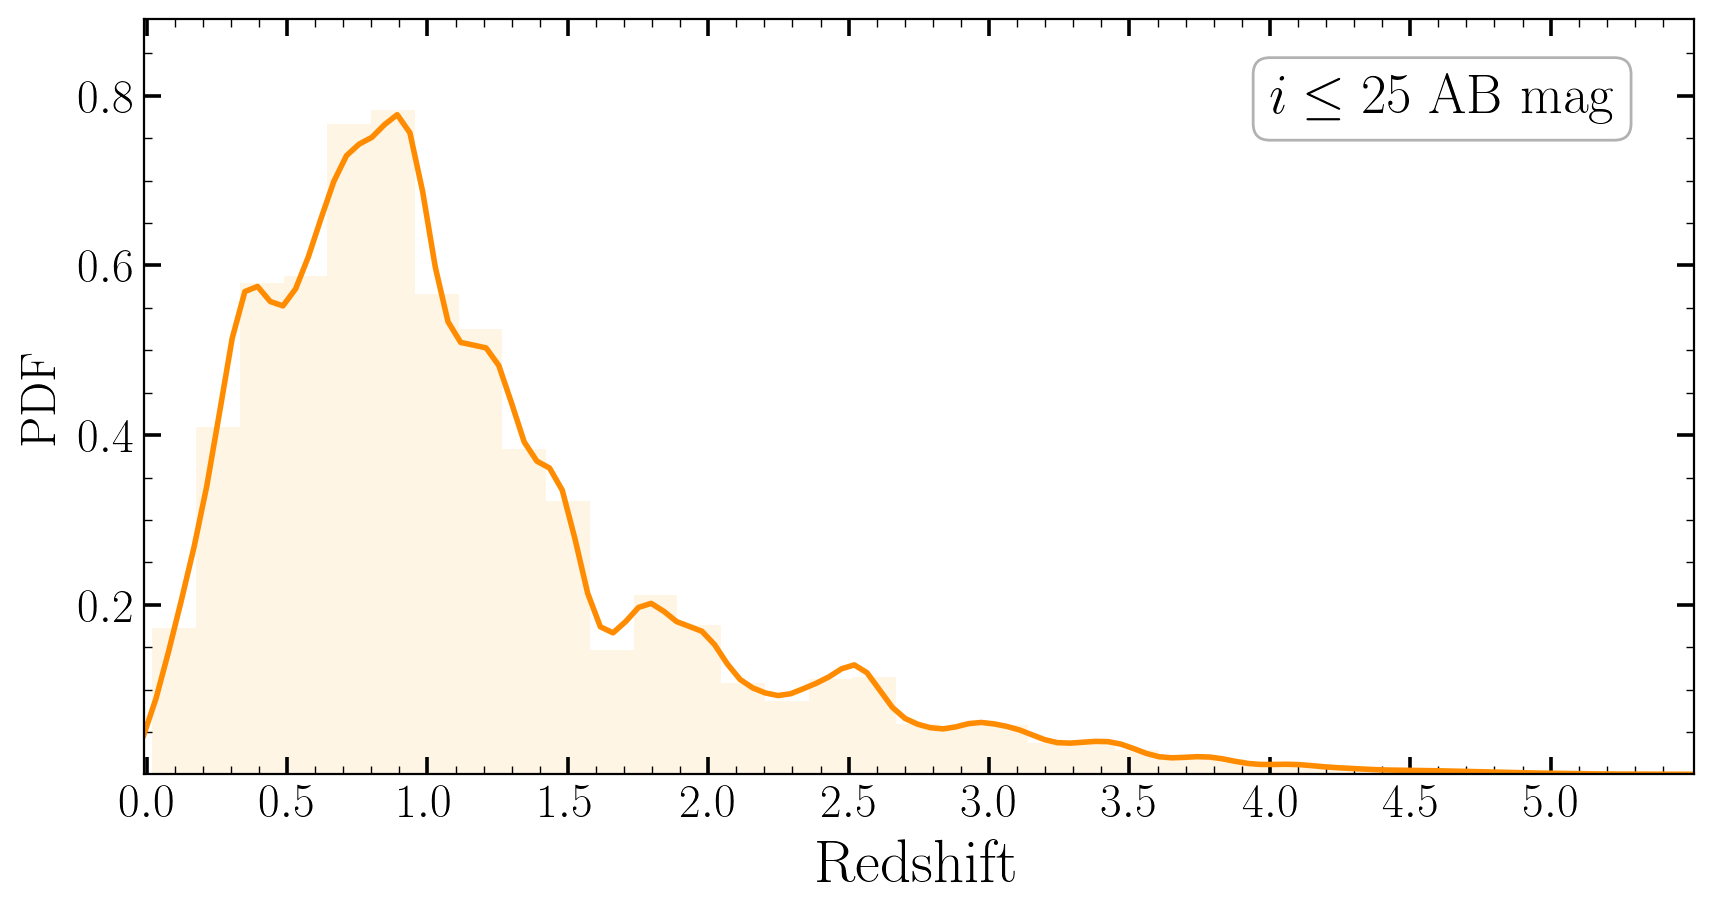

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))

x_major_ticks = np.arange(0, 5.5, 0.5)
x_minor_ticks = np.arange(0, 5.5, 0.1)
y_major_ticks = np.arange(0, 1, 0.2)
y_minor_ticks = np.arange(0, 1, 0.05)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

dist_plot = sns.distplot(catalog_final.lp_zPDF,rug_kws={"color": "b"}, hist_kws={"alpha": 0.1, "color": "orange"}, kde=True,
             bins=int(55), color = 'darkorange',hist=True,
             kde_kws={'linewidth': 2},ax=ax,axlabel=False)

# Customize the tick parameters for major and minor ticks
ax.tick_params(which='major', direction='in', right=True, top=True, length=6, width=1.3, labelsize=17)
ax.tick_params(which='minor', direction='in', right=True, top=True, length=3, width=0.5)

ax.set_xlabel(r'$\mathrm{Redshift}$', fontsize=22, labelpad=5)
ax.set_ylabel(r'$\mathrm{PDF}$', fontsize=18, labelpad=5)

ax.set_xlim(-0.01, 5.51)
ax.set_ylim(1e-10, 0.89)

text_box_props = dict(boxstyle='round', facecolor='white', alpha=0.3)
ax.text(4.0, 0.78, r'$i \leq 25\ \mathrm{AB\ mag}$', fontsize=20, bbox=text_box_props, color='black')

# plt.savefig('Plots/z_PDF.pdf', dpi=100)

plt.show()


## Mutual information for continuous variables

In [135]:
class KSGMutualInformation:
    def __init__(self, n_neighbors, norm='chebyshev', unit='nat'):
        """
        Initialize the estimator for mutual information.
        
        Parameters
        ----------
        n_neighbors : int
            The number of nearest neighbors to consider.
        
        norm : {'chebyshev', 'euclidean'}, default='chebyshev'
            The norm to use for computing distances.
        
        unit : {'nat', 'bit'}, default='nat'
            The unit of the computed mutual information.
            
        Notes
        -----
        The mutual information is computed using the KSG (Kraskov, Stögbauer and Grassberger)
        method. The result is returned in the specified unit, either 'nats' or 'bits'.
        
        """
        self.n_neighbors = n_neighbors
        self.norm = norm
        self.unit = unit
        
    def mi(self, x, y):
        """
        Compute mutual information between two continuous variables.

        Parameters
        ----------
        x, y : ndarray, shape (n_samples,)
            Samples of two continuous random variables, must have an identical shape.

        Returns
        -------
        mi : float
            Estimated mutual information. If it turns out to be negative,
            it is replaced by 0.
        """
        # data scaling is common practice; however, its effect is minimal when using the Chebyshev norm.
        # x=self.scale(x) 
        # y=self.scale(y)
        
        n_samples = x.size
        x = x.reshape((-1, 1))
        y = y.reshape((-1, 1))
        xy = np.c_[x, y]

        nn = NearestNeighbors(metric=self.norm, n_neighbors=self.n_neighbors)
        nn.fit(xy)
        radius = nn.kneighbors()[0]
        radius = np.nextafter(radius[:, -1], 0)

        kd_x = KDTree(x, metric=self.norm)
        kd_y = KDTree(y, metric=self.norm)

        nx = kd_x.query_radius(x, radius, count_only=True) - 1
        ny = kd_y.query_radius(y, radius, count_only=True) - 1

        mi = digamma(n_samples) + digamma(self.n_neighbors) - np.mean(digamma(nx + 1)) - np.mean(digamma(ny + 1))
        if self.unit == 'bit':
            mi /= np.log(2)
        return max(0, mi)

    def pmi(self, x, y, z):
        """
        Compute the partial mutual information (PMI) using the KSG method.

        Parameters
        ----------
        x, y, z : ndarray, shape (n_samples, n_features)
            Samples from continuous random variables.

        Returns
        -------
        pmi : float
            Estimated partial mutual information. If it turns out to be negative,
            it is replaced by 0.
        """
        # Combine the variables to form joint distributions
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        xyz = np.c_[x, y, z]
        if z.ndim == 1:
            z = z.reshape(-1, 1)

        # Construct KD-trees
        tree_z= KDTree(z, metric=self.norm)
        tree_xz = KDTree(xz, metric=self.norm)
        tree_yz = KDTree(yz, metric=self.norm)
        tree_xyz = KDTree(xyz, metric=self.norm)

        # Query the k-th nearest neighbor distances
        distances, _ = tree_xyz.query(xyz, k=self.n_neighbors + 1)
        epsilon = distances[:, -1]  # The k-th nearest distance

        # Count the number of points within epsilon distance in the marginal spaces
        nxz = tree_xz.query_radius(xz, epsilon, count_only=True) - 1
        nyz = tree_yz.query_radius(yz, epsilon, count_only=True) - 1
        nz = tree_z.query_radius(z, epsilon, count_only=True) - 1

        pmi = digamma(self.n_neighbors) + np.mean(digamma(nz + 1) - digamma(nxz + 1) - digamma(nyz + 1))

        # Convert to the desired unit if necessary
        if self.unit == 'bit':
            pmi /= np.log(2)

        return max(0, pmi)
    
#     def scale(self,X):
#         """
#         Scale input data to unit variance.

#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, n_features)
#             The data to scale.
#         Returns
#         -------
#         X_scaled : ndarray of shape (n_samples, n_features)
#             The scaled data.
#         """
#         scale_ = np.nanstd(X, axis=0, keepdims=True)
#         X /= scale_

#         return X

#### Figure2: Mutual information of redshift and wavebands

In [136]:
ksg = KSGMutualInformation(n_neighbors=100,unit='bit')

In [137]:
# Initialize an array to hold the mutual information values
mi_z_values = np.zeros(len(selected_flux_columns))

# Compute mutual information for each band with lp_zPDF
for i, column in enumerate(selected_flux_columns):
    mi_z_values[i] = ksg.mi(catalog_final[column].values, catalog_final['lp_zPDF'].values)

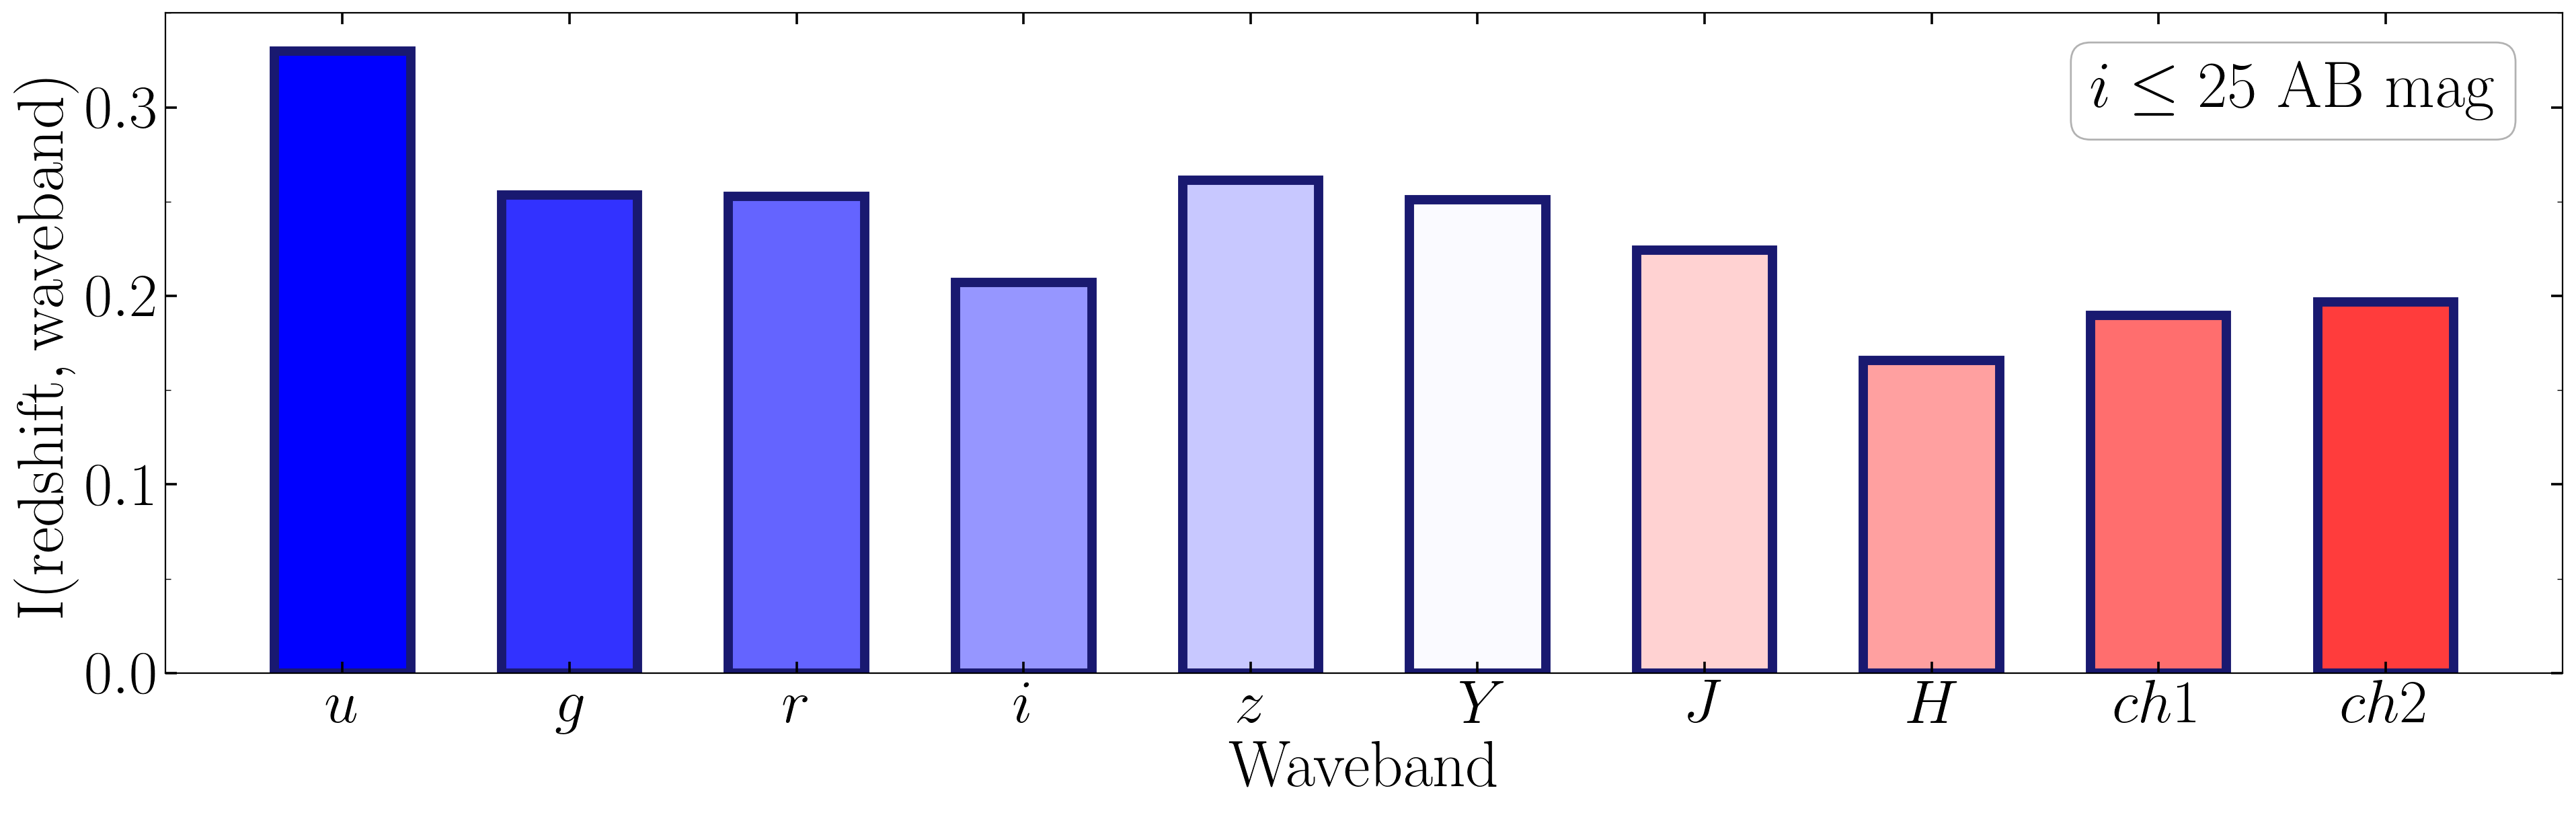

In [138]:
fig, ax = plt.subplots(figsize=(23, 6.5))

waveband_labels = ['$u$', '$g$', '$r$', '$i$', '$z$', '$Y$', '$J$', '$H$', '$ch1$', '$ch2$']

# Set the color map
cm = plt.cm.get_cmap('bwr')

ax.bar(
    waveband_labels,
    mi_z_values,
    width=0.6,
    edgecolor='midnightblue',
    linewidth=5,
    color=[cm(i) for i in range(0, 250, 25)]  
)

ax.set_ylabel(r'$\mathrm{I(redshift,wave band)}$', fontsize=35)
ax.set_xlabel(r'$\mathrm{Wave band}$', fontsize=35)

ax.tick_params(which='major', direction='in', right=True, top=True, length=6, width=1.3, labelsize=33)
ax.tick_params(which='minor', direction='in', right=True, top=True, length=3, width=0.5)

ymajor_ticks = np.arange(0, 0.6, 0.1)
yminor_ticks = np.arange(0, 0.6, 0.05)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

ax.set_ylim(0, 0.35)

props = dict(boxstyle='round', facecolor='white', alpha=0.3)
ax.text(7.7, 0.3, r'$ i \leq 25\ \mathrm{AB\ mag} $', fontsize=35, bbox=props, color='black')

# plt.savefig('Plots/info.pdf', dpi=100, bbox_inches='tight')  # Save in data folder for user retrieval

plt.show()


#### Figure3: Conditional mutual information of redshift and wavebands

In [139]:
def select_band_based_on_pmi(selected_bands, target_variable, ksg_instance):
    """
    Selects the band that maximizes pmi with the target variable,
    given the already selected bands.

    Parameters
    ----------
    selected_bands : list of str
        The bands that have already been selected.
    target_variable : str
        The name of the target variable in the dataframe.
    ksg_instance : KSG
        An instance of the KSG class that can compute PMI.
    selected_flux_columns : list of str
        All possible bands that can be selected.
    catalog_final : DataFrame
        The dataframe containing the flux values for all bands and the target variable.

    Returns
    -------
    selected_band : str
        The newly selected band based on the highest PMI.
    pmi_values : list of tuples
        A list containing tuples of band names and their corresponding PMI values.
    """
    
    # Determine the remaining bands to consider for selection
    remaining_bands = [band for band in selected_flux_columns if band not in selected_bands]
    current_step = len(selected_bands) 
    total_steps = len(selected_flux_columns)-1
    
    # Initialize a list to store PMI values for each band
    pmi_values = []
    
    # Set up the progress bar
    tqdm_desc = f"Step {current_step}/{total_steps}:"
    for band in tqdm(remaining_bands, desc=tqdm_desc):
        # Calculate PMI for the band against the target variable, given the known bands
        known_bands_data = catalog_final[selected_bands].values
        pmi = ksg_instance.pmi(catalog_final[[band]].values, catalog_final[target_variable].values, known_bands_data)
        
        # Store the band and its PMI value
        pmi_values.append((band, pmi))
    
    # Select the band with the highest PMI value
    selected_band, _ = max(pmi_values, key=lambda x: x[1])
    
    return selected_band, pmi_values

In [140]:
# Initialize the selection process
band_name_mapping = {
    'CFHT_u_FLUX': '$u$',
    'HSC_g_FLUX': '$g$',
    'HSC_r_FLUX': '$r$',
    'HSC_i_FLUX': '$i$',
    'HSC_z_FLUX': '$z$',
    'UVISTA_Y_FLUX': '$Y$',
    'UVISTA_J_FLUX': '$J$',
    'UVISTA_H_FLUX': '$H$',
    'IRAC_CH1_FLUX': '$ch1$',
    'IRAC_CH2_FLUX': '$ch2$'
}

target_variable = 'lp_zPDF'
selected_bands = ['HSC_i_FLUX']  # Starting with i-band
selection_steps = {}
step = 1
while len(selected_bands) < len(selected_flux_columns):
    new_band, pmi_values = select_band_based_on_pmi(selected_bands, target_variable, ksg)
    selected_bands.append(new_band)
    
    # Update the selection steps dictionary
    selection_steps[step] = {
        'selected_band': new_band,
        'pmi_score': np.array(pmi_values)[:,1].astype(float),
        'labels': [band_name_mapping.get(name) for name in np.array(pmi_values)[:,0]]
    }
    
    print(f"Step {step} output: Selected {new_band}")
    time.sleep(0.5)  # Pause for half a second
    step += 1

Step 1/9:: 100%|██████████| 9/9 [01:19<00:00,  8.79s/it]


Step 1 output: Selected HSC_r_FLUX


Step 2/9:: 100%|██████████| 8/8 [02:17<00:00, 17.22s/it]


Step 2 output: Selected CFHT_u_FLUX


Step 3/9:: 100%|██████████| 7/7 [03:13<00:00, 27.71s/it]


Step 3 output: Selected IRAC_CH2_FLUX


Step 4/9:: 100%|██████████| 6/6 [02:18<00:00, 23.04s/it]


Step 4 output: Selected HSC_z_FLUX


Step 5/9:: 100%|██████████| 5/5 [02:15<00:00, 27.11s/it]


Step 5 output: Selected UVISTA_Y_FLUX


Step 6/9:: 100%|██████████| 4/4 [02:25<00:00, 36.29s/it]


Step 6 output: Selected UVISTA_J_FLUX


Step 7/9:: 100%|██████████| 3/3 [02:14<00:00, 44.99s/it]


Step 7 output: Selected IRAC_CH1_FLUX


Step 8/9:: 100%|██████████| 2/2 [01:46<00:00, 53.12s/it]


Step 8 output: Selected UVISTA_H_FLUX


Step 9/9:: 100%|██████████| 1/1 [01:03<00:00, 63.82s/it]


Step 9 output: Selected HSC_g_FLUX


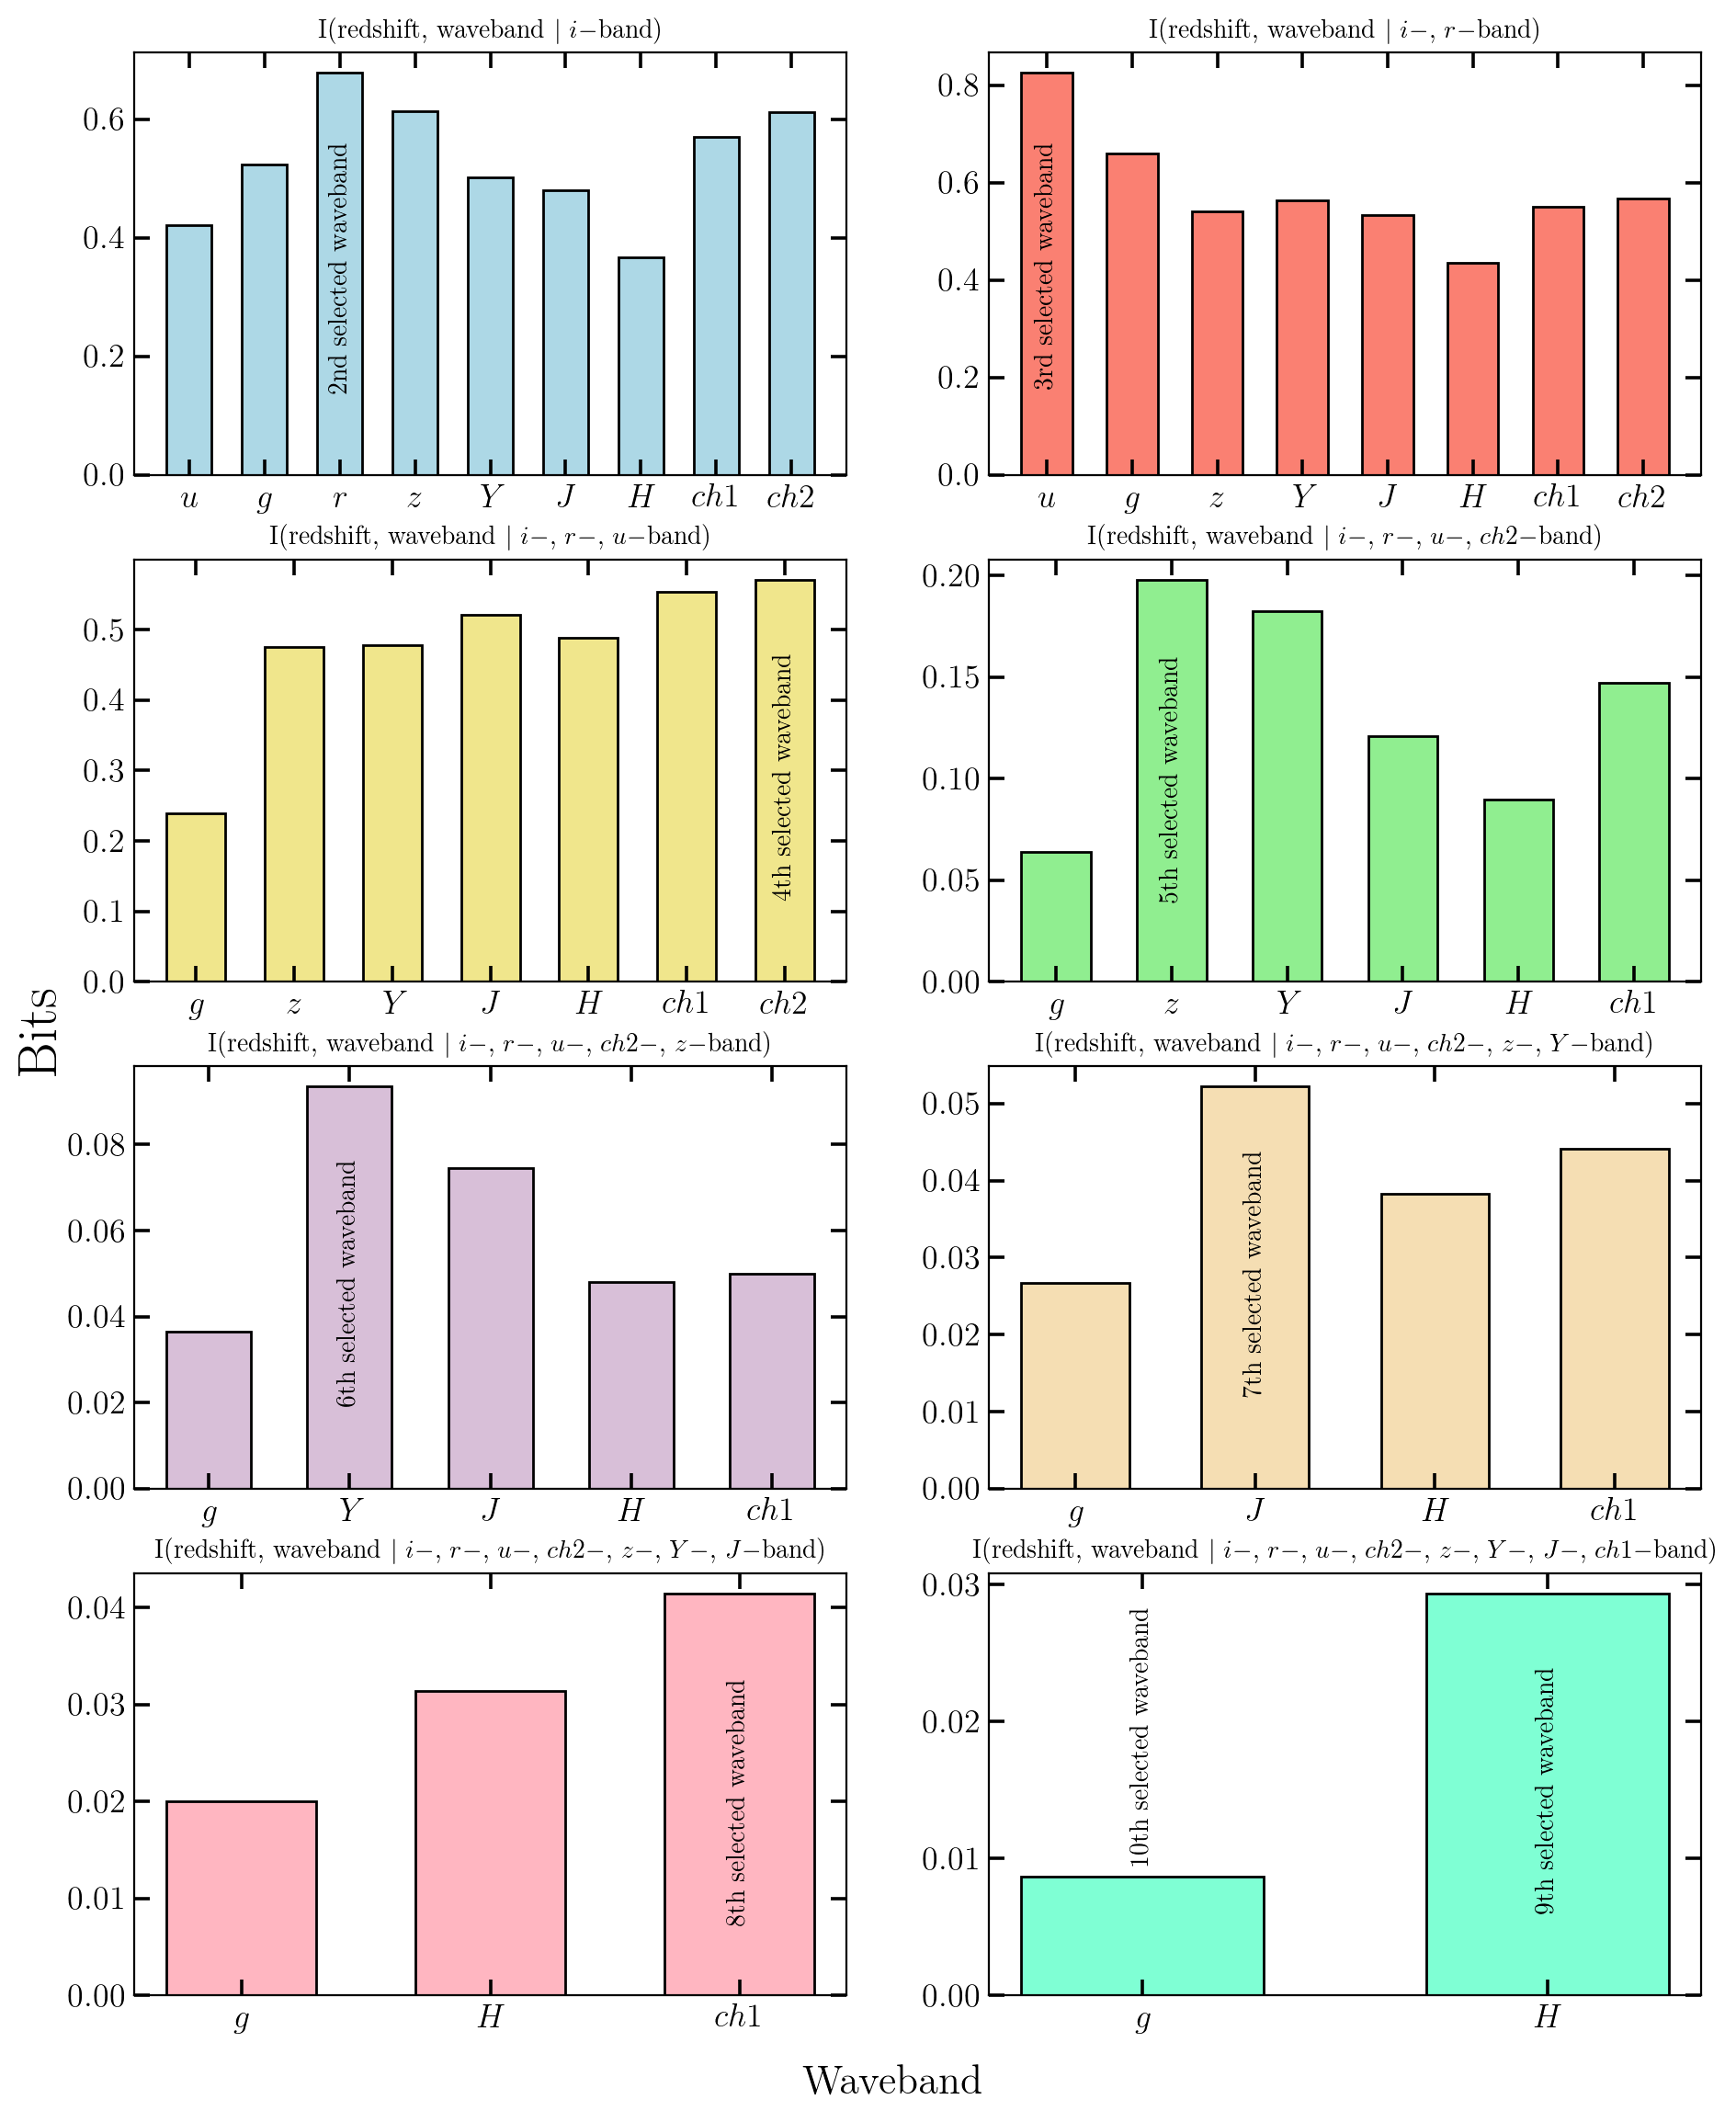

In [51]:
fig, axes = plt.subplots(4, 2, figsize=(11, 14))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

accumulated_selected_bands = ['$i$']
colors = ['lightblue', 'salmon', 'khaki', 'lightgreen', 'Thistle', 'Wheat', 'lightpink', 'Aquamarine']

for step, ax in enumerate(axes, start=1):
    if step in selection_steps:
        data = selection_steps[step]
        labels = data['labels']  # Labels for the x-axis
        pmi_scores = data['pmi_score']  # PMI scores for the y-axis
        selected_band = band_name_mapping.get(data['selected_band'])  # The band selected in this step
        accumulated_selected_bands.append(selected_band)  # Add the newly selected band
        
        # Plot the bars
        ax.bar(labels, pmi_scores, width=0.6, edgecolor='black', linewidth=1, color=colors[step-1])
        ax.tick_params(which = 'major',direction='in',right='on',top='on',length=6,width=1.3,labelsize=13)
        ax.tick_params(which = 'minor',direction='in',right='on',top='on',length=3,width=0.5)

        # # Set the title with the selected bands up to the current step
        accumulated_selected_bands_with_dash = [band[:-1] + '-$' for band in accumulated_selected_bands]
        title_bands = ', '.join( accumulated_selected_bands_with_dash[:-1])  # Exclude the current selected band

        ax.set_title(f'I(redshift, waveband $|$ {title_bands}band)', fontsize=10)

fig.text(0.08, 0.5, '$\\rm{Bits}$', ha='center', va='center', rotation='vertical',fontsize=22)
fig.text(0.5, 0.09, '$\\rm{Waveband}$', ha='center', va='center',fontsize=16)

axes[0].text(['$r$'],0.35,'2nd selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[1].text(['$u$'],0.43,'3rd selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[2].text(['$ch2$'],0.29,'4th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[3].text(['$z$'],0.1,'5th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[4].text(['$Y$'],0.048,'6th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[5].text(['$J$'],0.028,'7th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[6].text(['$ch1$'],0.02,'8th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[7].text(['$H$'],0.015,'9th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[7].text(['$g$'],0.019,'10th selected waveband',rotation=90,ha='center', va='center',fontsize=10)

# plt.savefig('Plots/info_cond.pdf', dpi=150, bbox_inches='tight')
plt.show()

I will now repeat the same analysis for the stellar mass:

#### Figure4: Mutual information of stellar mass and wavebands

In [52]:
# Initialize an array to hold the mutual information values
mi_m_values = np.zeros(len(selected_flux_columns))

# Compute mutual information for each band with lp_mass_med
for i, column in enumerate(selected_flux_columns):
    mi_m_values[i] = ksg.mi(catalog_final[column].values, catalog_final['lp_mass_med'].values)

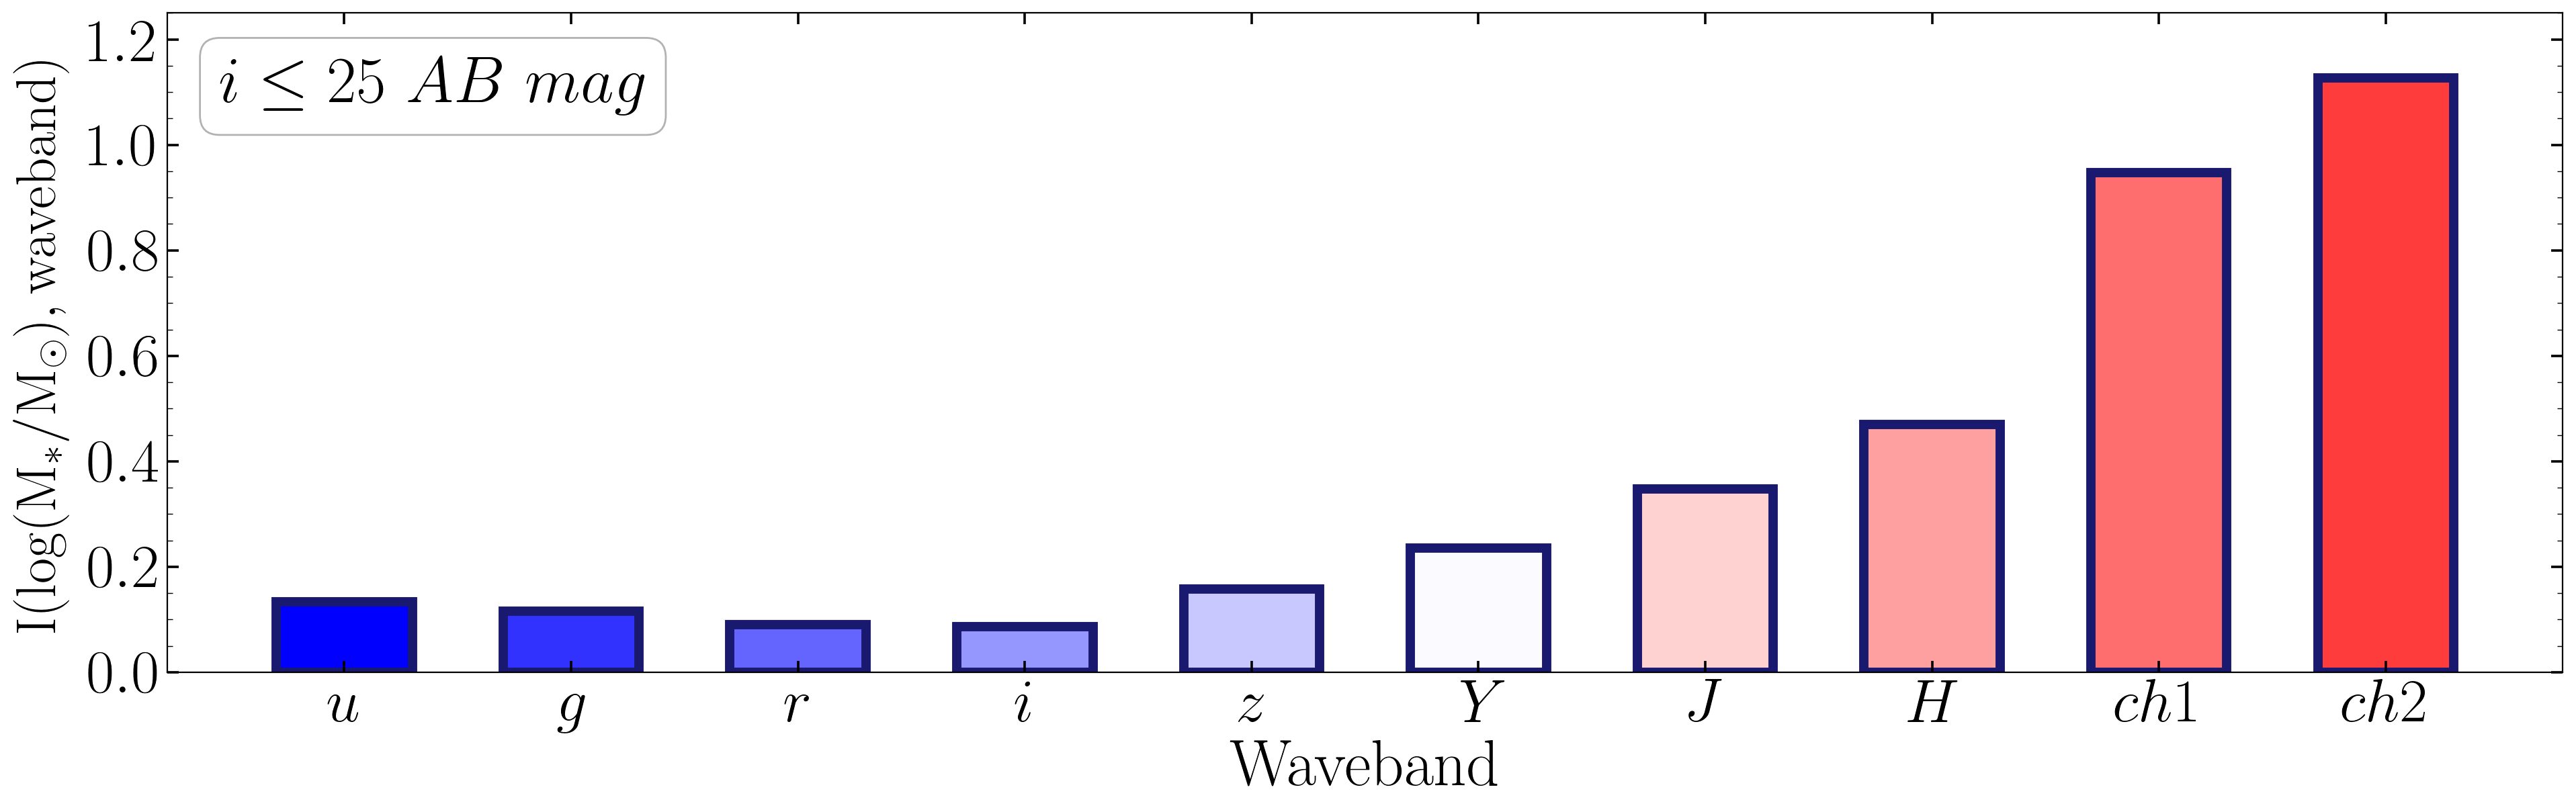

In [55]:
fig, ax = plt.subplots(figsize=(23, 6.5))

waveband_labels = ['$u$', '$g$', '$r$', '$i$', '$z$', '$Y$', '$J$', '$H$', '$ch1$', '$ch2$']

# Set the color map
cm = plt.cm.get_cmap('bwr')

ax.bar(
    waveband_labels,
    mi_m_values,
    width=0.6,
    edgecolor='midnightblue',
    linewidth=5,
    color=[cm(i) for i in range(0, 250, 25)]  
)

plt.ylabel('$\\rm{I(\\log(M_*/M_\odot),waveband)}$',fontsize=30,labelpad=10)
ax.set_xlabel(r'$\mathrm{Wave band}$', fontsize=35)

ax.tick_params(which='major', direction='in', right=True, top=True, length=6, width=1.3, labelsize=33)
ax.tick_params(which='minor', direction='in', right=True, top=True, length=3, width=0.5)

ymajor = np.arange(0,1.5,0.2)
yminor = np.arange(0,1.5,0.05)
ax.set_yticks(ymajor)
ax.set_yticks(yminor,minor=True)

ax.set_ylim(0,1.25)

props = dict(boxstyle='round', facecolor='white', alpha=0.3)
ax.text(-0.55,0.73+0.35,' $ i\leq 25\ AB\ mag $ ',fontsize=35, bbox=props,color='black')

# plt.savefig('Plots/info_mass.pdf',dpi=100,bbox_inches='tight')
plt.show()


#### Figure5:Mutual information of stellar mass and wavebands in the bins of redshift

In [65]:
def info_redshift_bin(z1,z2):
    catalog_final_redshift_bin=catalog_final[(catalog_final.lp_zPDF>=z1)&(catalog_final.lp_zPDF<z2)]
    # Initialize an array to hold the mutual information values
    mi_red_bin_values = np.zeros(len(selected_flux_columns))

    # Compute mutual information for each band with lp_mass_med
    for i, column in enumerate(selected_flux_columns):
        mi_red_bin_values[i] = ksg.mi(catalog_final_redshift_bin[column].values, catalog_final_redshift_bin['lp_mass_med'].values)
        
    return  mi_red_bin_values

In [66]:
interval_step = 0.5
max_value = 5.0

# Generate the intervals.
intervals = [(i, i + interval_step) for i in np.arange(0, max_value, interval_step)]

# Calculate the information scores for each interval and stack them vertically.
Importance_mass_redshift_bin = np.vstack([info_redshift_bin(start, end) for start, end in intervals])

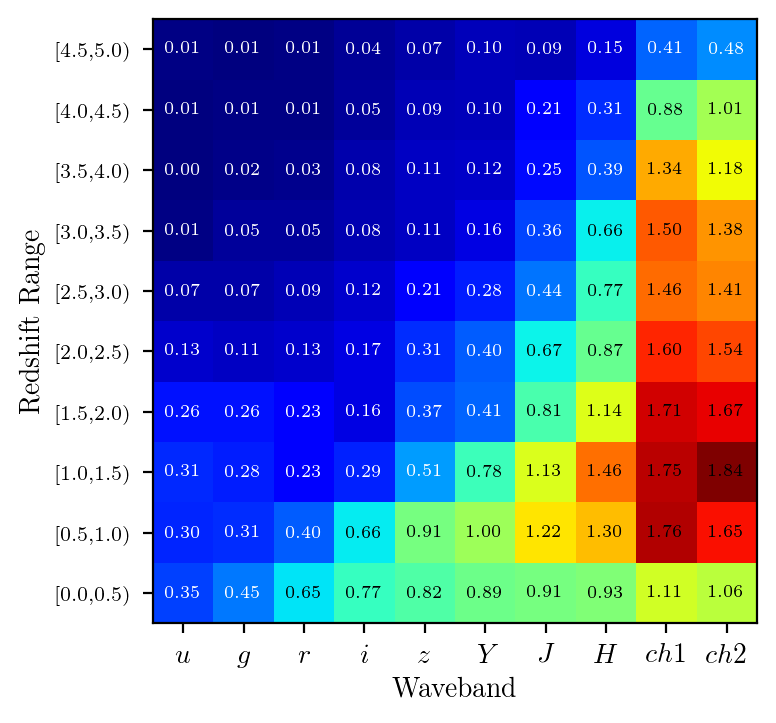

In [71]:
fig, ax = plt.subplots()

ax.imshow(Importance_mass_redshift_bin,origin='lower',cmap='jet')
bands = ['$u$','$g$','$r$','$i$','$z$','$Y$','$J$','$H$','$ch1$','$ch2$']

ax.set_xticks(np.arange(len(bands)))
ax.set_yticks(np.arange(len(bands)))
ax.set_xticklabels(bands,fontsize=10)
ax.set_yticklabels(['[0.0,0.5)','[0.5,1.0)','[1.0,1.5)','[1.5,2.0)','[2.0,2.5)','[2.5,3.0)','[3.0,3.5)','[3.5,4.0)','[4.0,4.5)','[4.5,5.0)'],fontsize=7)


for i in range(len(bands)):
    for j in range(len(bands)):
        if  round(Importance_mass_redshift_bin[i, j],2)<0.65:
            text = ax.text(j, i, "{:.2f}".format(round(Importance_mass_redshift_bin[i, j],2)),
                       ha="center", va="center", color="w",size=6)
        else:
            text = ax.text(j, i, "{:.2f}".format(round(Importance_mass_redshift_bin[i, j],2)),
                       ha="center", va="center", color="black",size=6)
            
            

ax.set_ylabel('$\\rm{Redshift\ Range}$',fontsize=10)
ax.set_xlabel('$\\rm{Waveband}$',fontsize=10)

# plt.savefig('Plots/mi_mass_z.pdf',dpi=200,bbox_inches='tight')

plt.show()

#### Figure6: Conditional mutual information of stellar mass and wavebands

In [56]:
target_variable = 'lp_mass_med'
selected_bands = ['HSC_i_FLUX']  # Starting with i-band
selection_steps_mass = {}
step = 1
while len(selected_bands) < len(selected_flux_columns):
    new_band, pmi_values = select_band_based_on_pmi(selected_bands, target_variable, ksg)
    selected_bands.append(new_band)
    
    # Update the selection steps dictionary
    selection_steps_mass[step] = {
        'selected_band': new_band,
        'pmi_score': np.array(pmi_values)[:,1].astype(float),
        'labels': [band_name_mapping.get(name) for name in np.array(pmi_values)[:,0]]
    }
    
    print(f"Step {step} output: Selected {new_band}")
    time.sleep(0.5)  # Pause for half a second
    step += 1

Step 1/9:: 100%|██████████| 9/9 [01:23<00:00,  9.28s/it]


Step 1 output: Selected IRAC_CH2_FLUX


Step 2/9:: 100%|██████████| 8/8 [01:44<00:00, 13.11s/it]


Step 2 output: Selected UVISTA_Y_FLUX


Step 3/9:: 100%|██████████| 7/7 [02:10<00:00, 18.66s/it]


Step 3 output: Selected HSC_r_FLUX


Step 4/9:: 100%|██████████| 6/6 [02:19<00:00, 23.32s/it]


Step 4 output: Selected CFHT_u_FLUX


Step 5/9:: 100%|██████████| 5/5 [02:36<00:00, 31.28s/it]


Step 5 output: Selected IRAC_CH1_FLUX


Step 6/9:: 100%|██████████| 4/4 [02:35<00:00, 38.83s/it]


Step 6 output: Selected UVISTA_J_FLUX


Step 7/9:: 100%|██████████| 3/3 [02:20<00:00, 46.94s/it]


Step 7 output: Selected UVISTA_H_FLUX


Step 8/9:: 100%|██████████| 2/2 [01:55<00:00, 57.92s/it]


Step 8 output: Selected HSC_z_FLUX


Step 9/9:: 100%|██████████| 1/1 [01:07<00:00, 67.63s/it]


Step 9 output: Selected HSC_g_FLUX


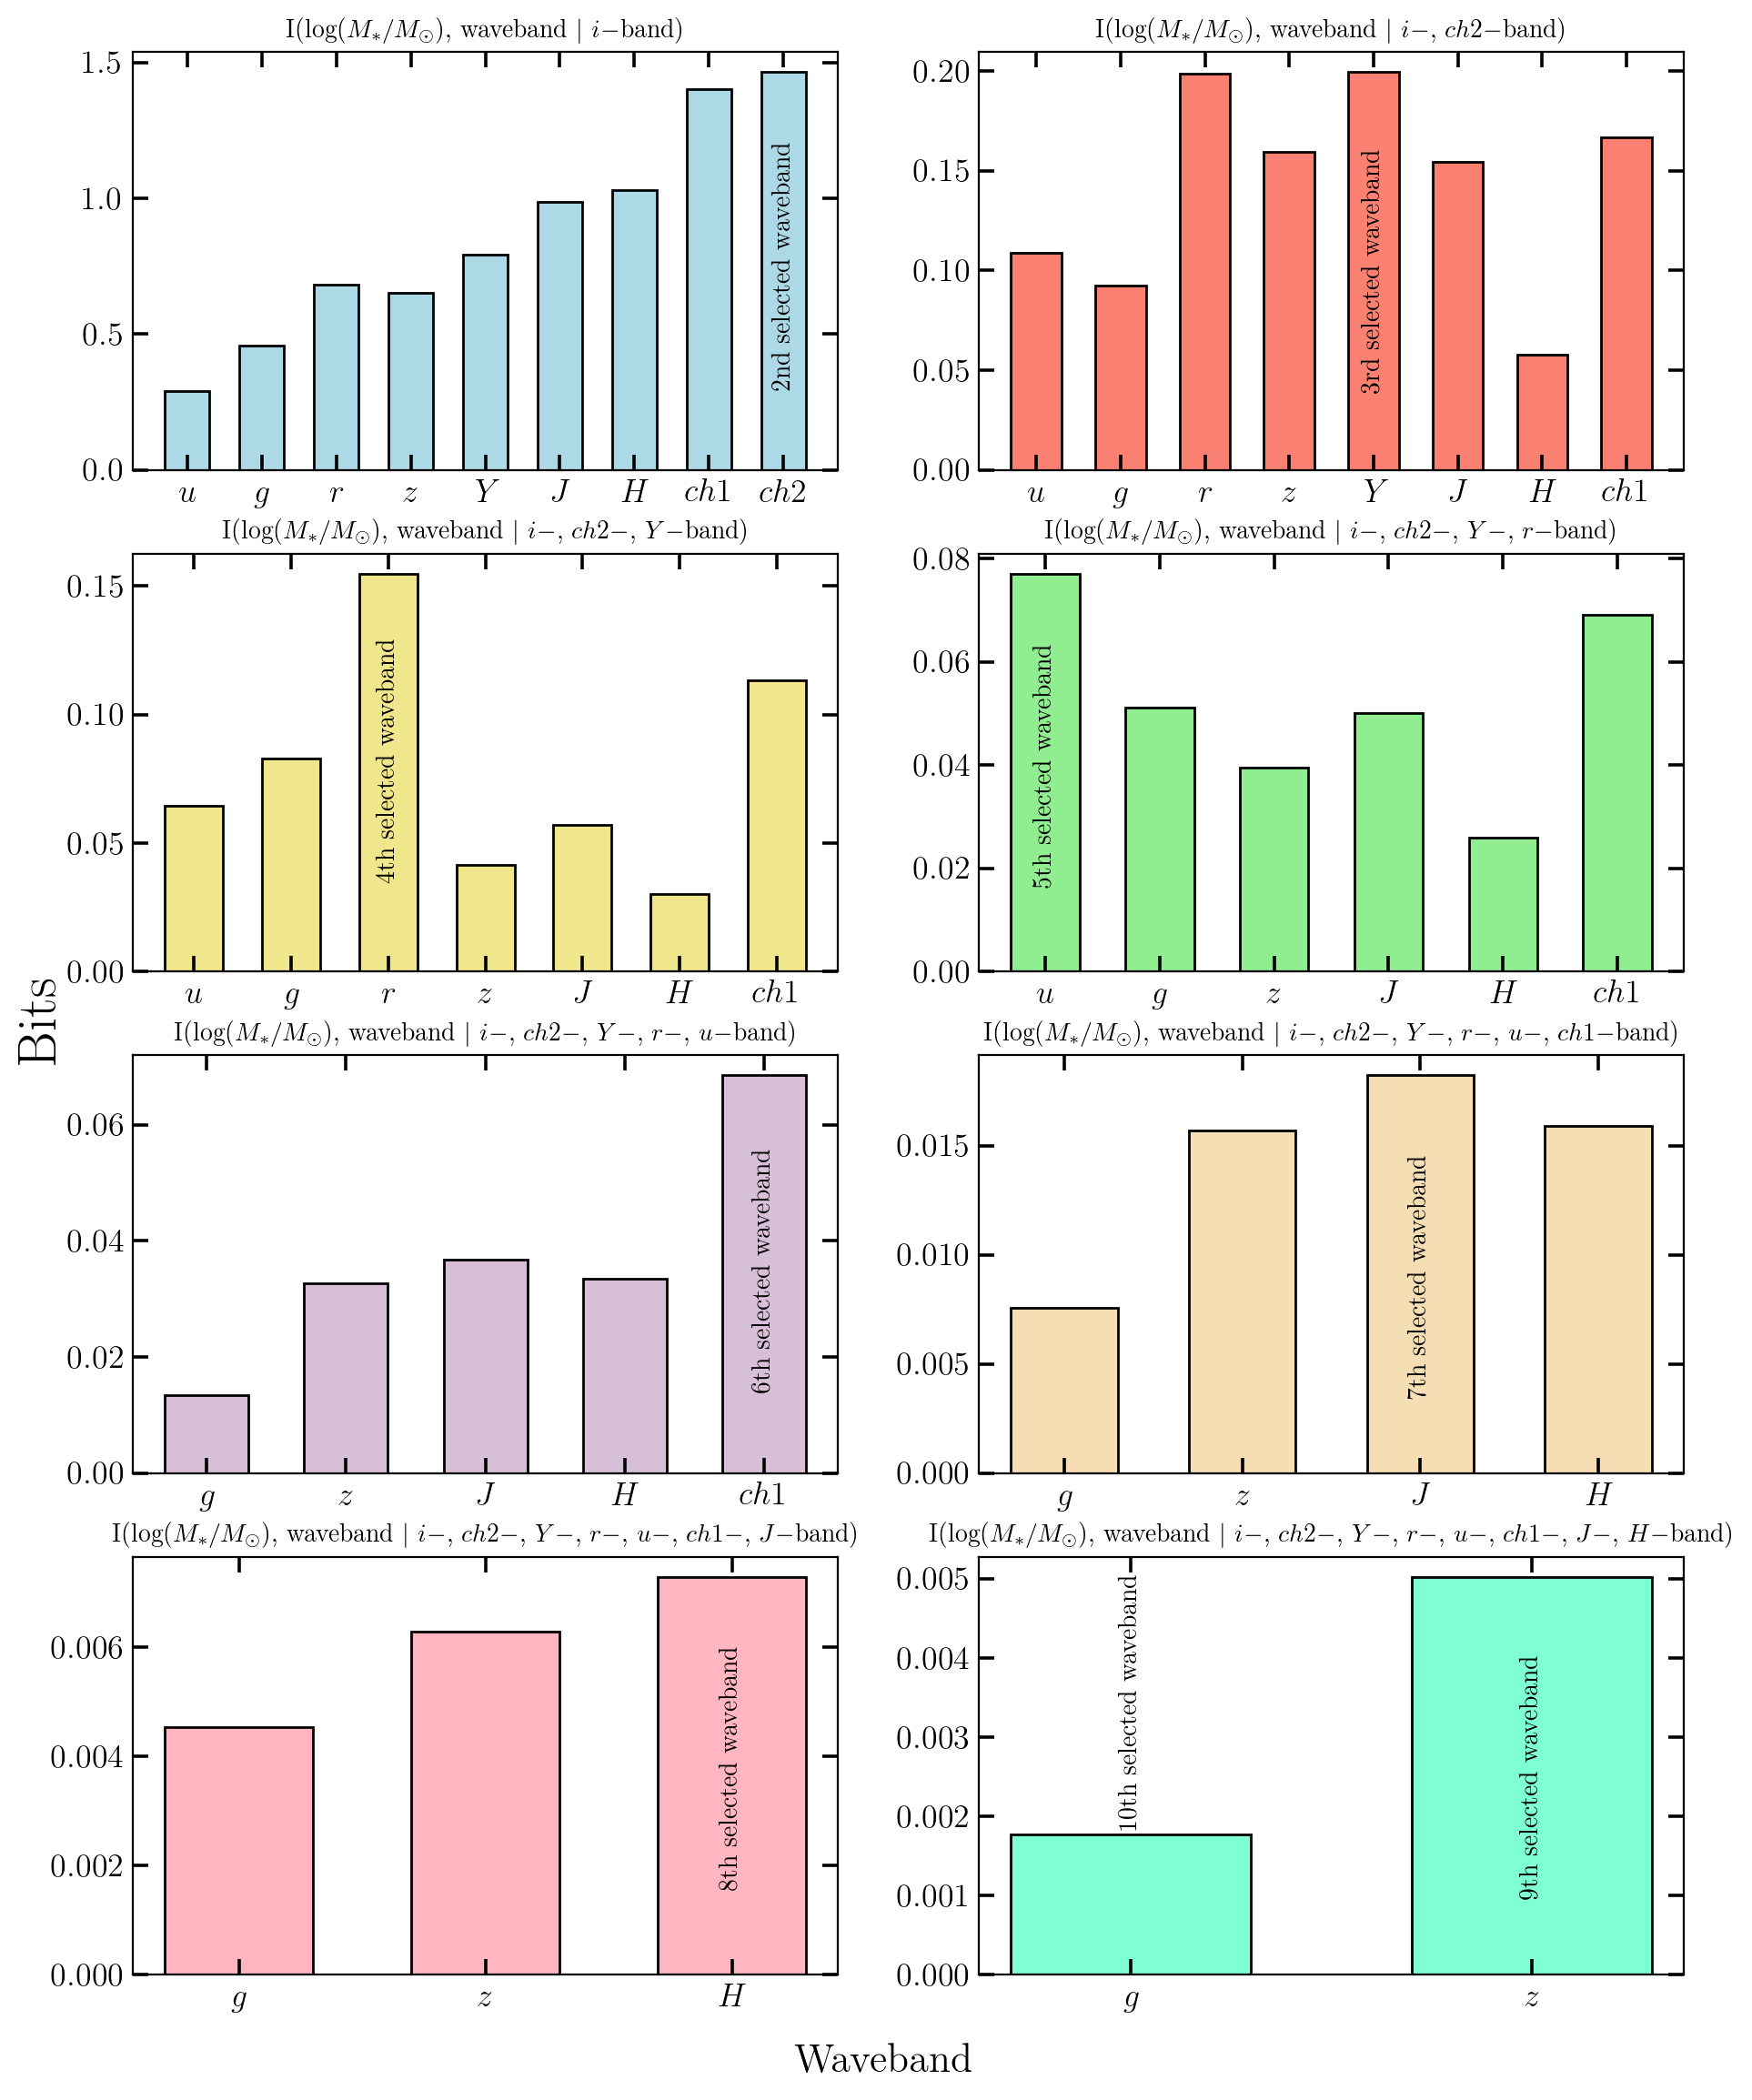

In [57]:
fig, axes = plt.subplots(4, 2, figsize=(11, 14))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

accumulated_selected_bands = ['$i$']
colors = ['lightblue', 'salmon', 'khaki', 'lightgreen', 'Thistle', 'Wheat', 'lightpink', 'Aquamarine']

for step, ax in enumerate(axes, start=1):
    if step in selection_steps_mass:
        data = selection_steps_mass[step]
        labels = data['labels']  # Labels for the x-axis
        pmi_scores = data['pmi_score']  # PMI scores for the y-axis
        selected_band = band_name_mapping.get(data['selected_band'])  # The band selected in this step
        accumulated_selected_bands.append(selected_band)  # Add the newly selected band
        
        ax.bar(labels, pmi_scores, width=0.6, edgecolor='black', linewidth=1, color=colors[step-1])
        ax.tick_params(which = 'major',direction='in',right='on',top='on',length=6,width=1.3,labelsize=13)
        ax.tick_params(which = 'minor',direction='in',right='on',top='on',length=3,width=0.5)

        accumulated_selected_bands_with_dash = [band[:-1] + '-$' for band in accumulated_selected_bands]
        title_bands = ', '.join( accumulated_selected_bands_with_dash[:-1])  # Exclude the current selected band

        ax.set_title(f'I($\\log(M_*/M_\odot)$, waveband $|$ {title_bands}band)', fontsize=10)

fig.text(0.08, 0.5, '$\\rm{Bits}$', ha='center', va='center', rotation='vertical',fontsize=22)
fig.text(0.5, 0.09, '$\\rm{Waveband}$', ha='center', va='center',fontsize=16)


axes[0].text(['$ch2$'],0.75,'2nd selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[1].text(['$Y$'],0.1,'3rd selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[2].text(['$r$'],0.082,'4th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[3].text(['$u$'],0.04,'5th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[4].text(['$ch1$'],0.035,'6th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[5].text(['$J$'],0.009,'7th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[6].text(['$H$'],0.0038,'8th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[7].text(['$z$'],0.0025,'9th selected waveband',rotation=90,ha='center', va='center',fontsize=10)
axes[7].text(['$g$'],0.00345,'10th selected waveband',rotation=90,ha='center', va='center',fontsize=10)


# plt.savefig('Plots/info_cond_mass.pdf', dpi=150, bbox_inches='tight')
plt.show()

#### Figure7:mutual information between different wave bands

In [77]:
# Initialize a dictionary to store mutual information for each band.
mutual_info_per_band = {}

# Calculate mutual information for each band and store it in the dictionary.
for index, band in enumerate(selected_flux_columns, start=1):  # Assuming the first column is 'u' band
    mutual_info=[]
    for i, column in enumerate(selected_flux_columns):
        mutual_info.append(ksg.mi(catalog_final[column].values, catalog_final[band].values))
    mutual_info_per_band[f'mutual_info_{band}'] = mutual_info

# Combine the mutual information of all bands into a single array.
mutual_info_band = np.concatenate([mutual_info for mutual_info in mutual_info_per_band.values()], axis=0)

In [96]:
mutual_info_band=mutual_info_band.reshape(10,10)
upper_triangle_indices = np.triu_indices(10, k=0) 
mutual_info_band[upper_triangle_indices] = np.nan 

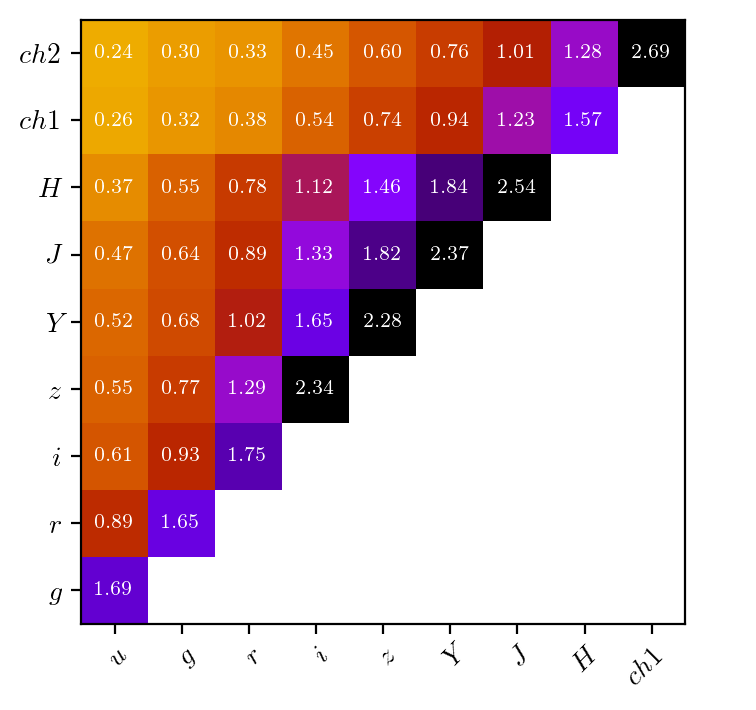

In [97]:
fig, ax = plt.subplots()

bands = ['$u$','$g$','$r$','$i$','$z$','$Y$','$J$','$H$','$ch1$','$ch2$']

im = ax.imshow(mutual_info_band,vmin=0,vmax=2,origin='lower',cmap='gnuplot_r')



ax.set_xticks(np.arange(len(bands)))
ax.set_yticks(np.arange(len(bands)))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(bands)):
    for j in range(len(bands)):
        if i!=0:
            text = ax.text(j, i, "{:.2f}".format(round(mutual_info_band[i, j],2)),
                           ha="center", va="center", color="w",size=7)
ax.set_xlim(-0.5,8.5)
ax.set_ylim(0.5,9.5)
ax.set_xticklabels(bands,fontsize=10)
ax.set_yticklabels(bands,fontsize=10)
# plt.savefig('Plots/mi_bands.pdf',dpi=200,bbox_inches='tight')
plt.show()

#### Figure8: Data Visualization with UMAP

I will use UMAP to create a 2D representation of H20-like observations (ugrizch1ch2). 

In [18]:
H20_bands=['CFHT_u_FLUX','HSC_g_FLUX','HSC_r_FLUX','HSC_i_FLUX','HSC_z_FLUX','IRAC_CH1_FLUX','IRAC_CH2_FLUX']

In [19]:
mapper_h20 = umap.UMAP(n_components=2,n_neighbors=50,random_state=42).fit(catalog_final[H20_bands].values)

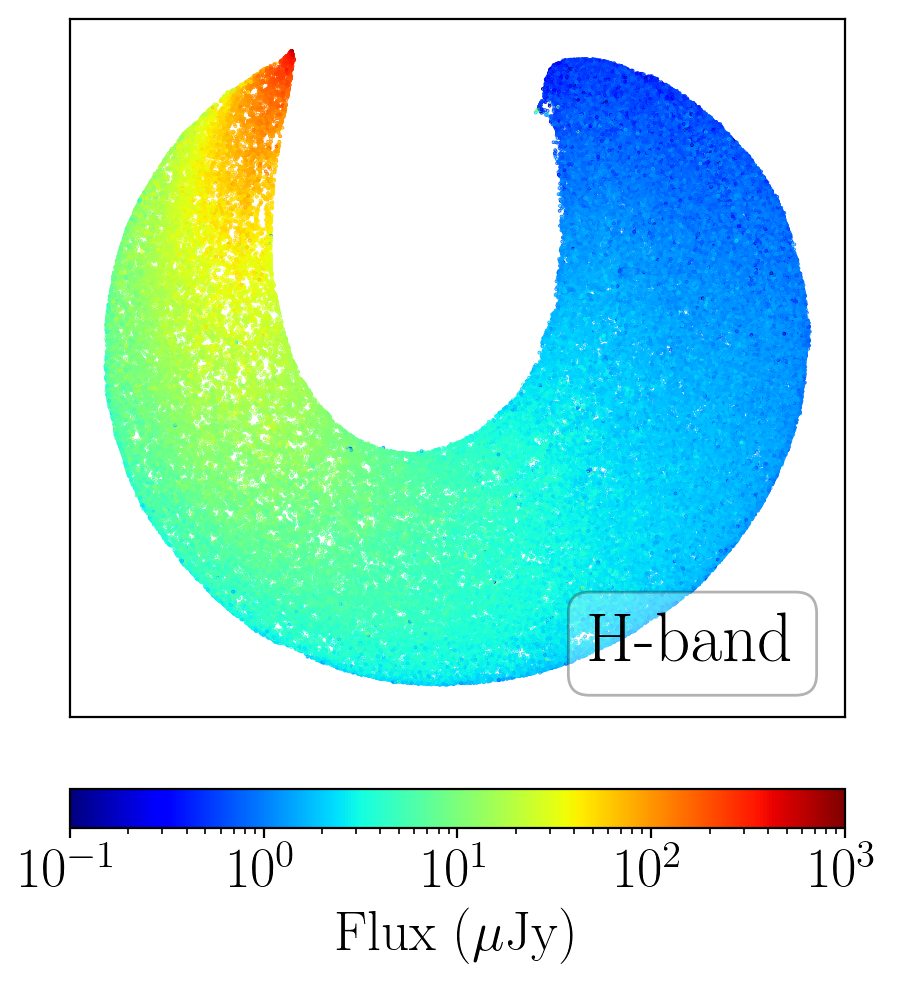

In [25]:
fig, ax = plt.subplots(figsize=(5, 6))

# Scatter plot for the UMAP embedding colored by the H-band flux
scatter = ax.scatter(
    *mapper_h20.embedding_.T,
    s=0.1,
    c=catalog_final['UVISTA_H_FLUX'],
    cmap='jet',
    norm=LogNorm(vmin=0.1, vmax=1000),
    rasterized=True
)

ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()
ax.invert_yaxis()

colorbar = fig.colorbar(scatter, orientation="horizontal", pad=0.08)
colorbar.ax.tick_params(axis='y', direction='in', labelsize=23, length=5, width=1.1)
colorbar.set_label('Flux ($\mu$Jy)', fontsize=20)

text_box_properties = dict(boxstyle='round', facecolor='white', alpha=0.3)
ax.text(0.67, 0.08, 'H-band', fontsize=25, bbox=text_box_properties, color='black', transform=ax.transAxes)

plt.subplots_adjust(wspace=0, hspace=0)
# fig.savefig('Plots/umap_flux.pdf', bbox_inches='tight')

plt.show()


The smooth gradient of H-band fluxes in the 2D representation shows that galaxies with similar fluxes in H20-like bands have similar H-band fluxes as well. Now, I will divide the sample into two sets, train and test, and build a model to predict near-IR fluxes based on H20-like data (ugrizch1ch2).

#### Figure9: Visualizing train and test sample

In [28]:
catalog_final_train,catalog_final_test,_,_=train_test_split(catalog_final,catalog_final,test_size=0.5,random_state=100)

In [30]:
mapper_h20_train = umap.UMAP(n_components=2,n_neighbors=50,random_state=42).fit(catalog_final_train[H20_bands].values)

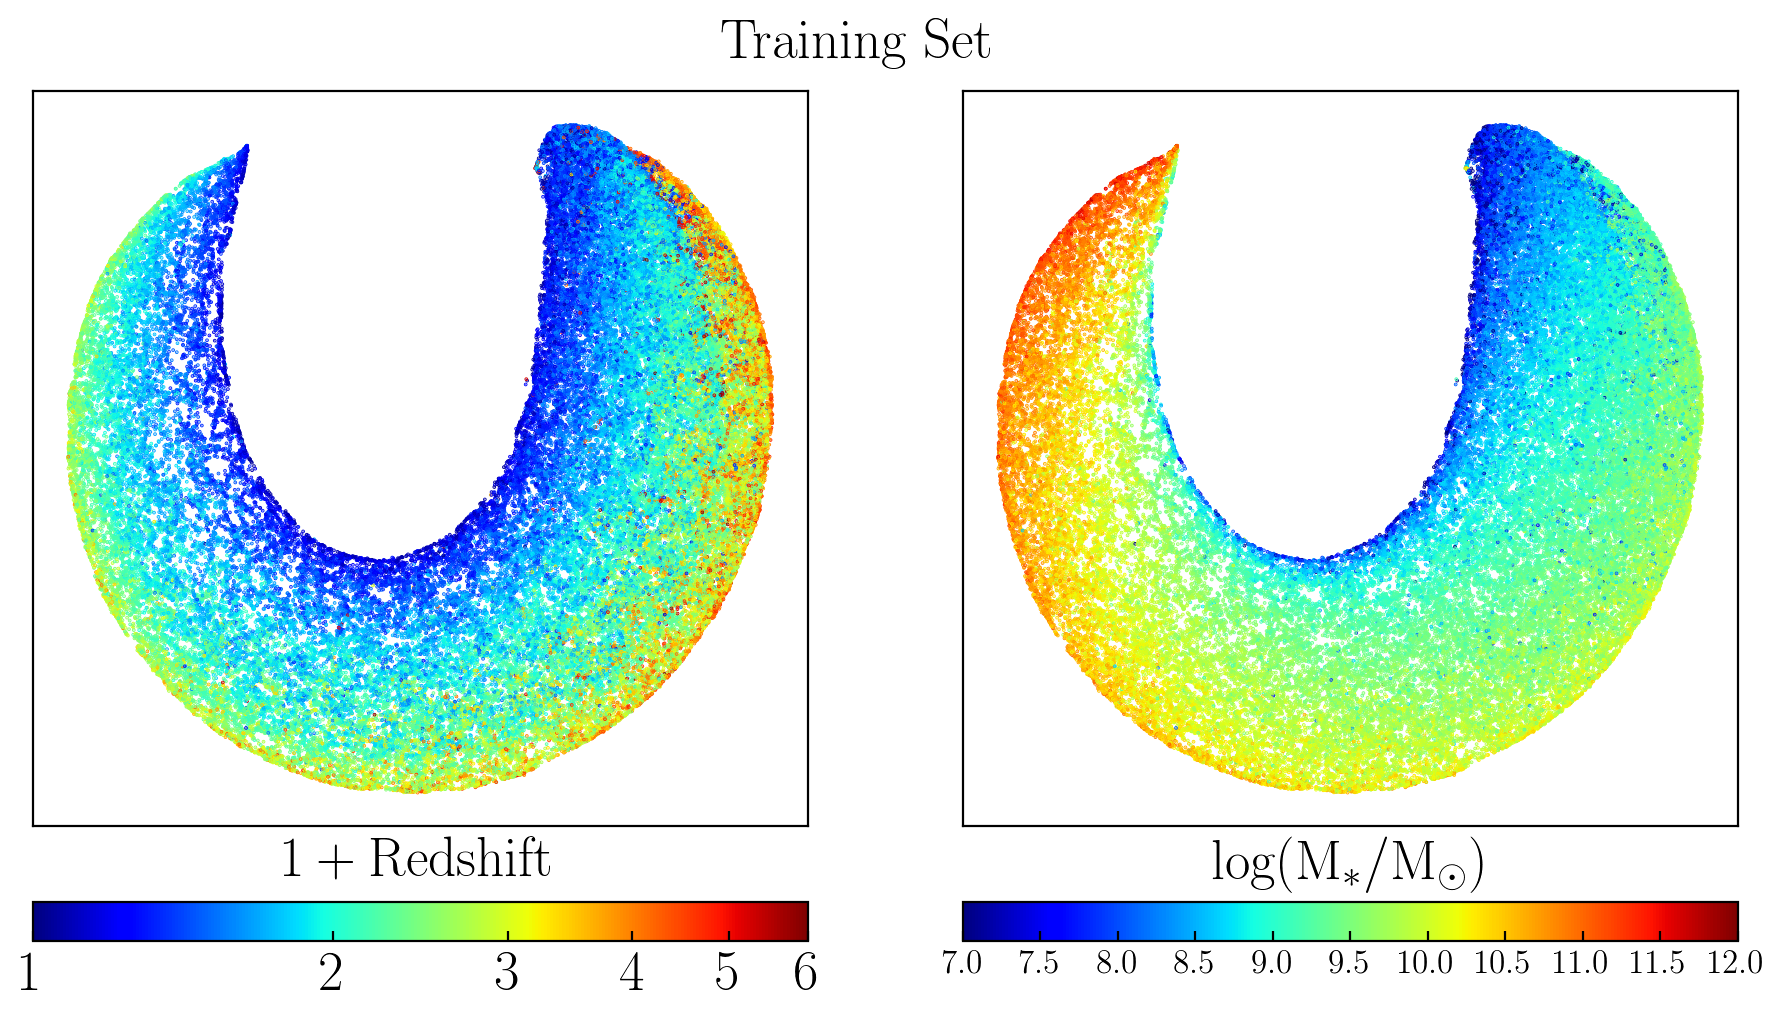

In [37]:
# Visualize the UMAP embedding for the training set
fig, ax = plt.subplots(1, 2, figsize=(11, 6))

props = dict(boxstyle='round', facecolor='white', alpha=0.3)

scatter_z = ax[0].scatter(
    *mapper_h20_train.embedding_.T, s=0.1,
    c=1 + catalog_final_train['lp_zPDF'], cmap='jet',
    norm=LogNorm(vmin=1, vmax=6),
    rasterized=True
)
cbar_z = fig.colorbar(scatter_z, orientation="horizontal", pad=0.08, format='%.0f', ax=ax[0])
cbar_z.ax.xaxis.set_ticks(np.arange(1, 7))
ax[0].set_xlabel(r'$\rm 1+Redshift$', fontsize=20)
ax[0].invert_xaxis()
ax[0].invert_yaxis()
cbar_z.ax.tick_params(axis='y', direction='in',labelsize=23,length=5,width=1.1)
cbar_z.ax.tick_params(axis='x', direction='in')

scatter_mass = ax[1].scatter(
    *mapper_h20_train.embedding_.T, s=0.1,
    c=catalog_final_train['lp_mass_med'], cmap='jet',
    vmin=7, vmax=12,
    rasterized=True
)
cbar_mass = fig.colorbar(scatter_mass, orientation="horizontal", pad=0.08, ax=ax[1])
cbar_mass.ax.xaxis.set_ticks(np.linspace(7, 12, num=11))
ax[1].set_xlabel(r'$\rm log(M_*/M_\odot)$', fontsize=20)
ax[1].invert_xaxis()
ax[1].invert_yaxis()
cbar_mass.ax.tick_params(axis='y', direction='in',labelsize=10,length=5,width=1.1)
cbar_mass.ax.tick_params(axis='x', direction='in',labelsize=12)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
fig.suptitle('Training Set', fontsize=20)
fig.subplots_adjust(top=0.92)
# fig.savefig('Plots/umap_train.pdf', bbox_inches='tight')
plt.show()


Is the training sample representative? Let's map test set.

In [38]:
test_transform=mapper_h20_train.transform(catalog_final_test[H20_bands].values)

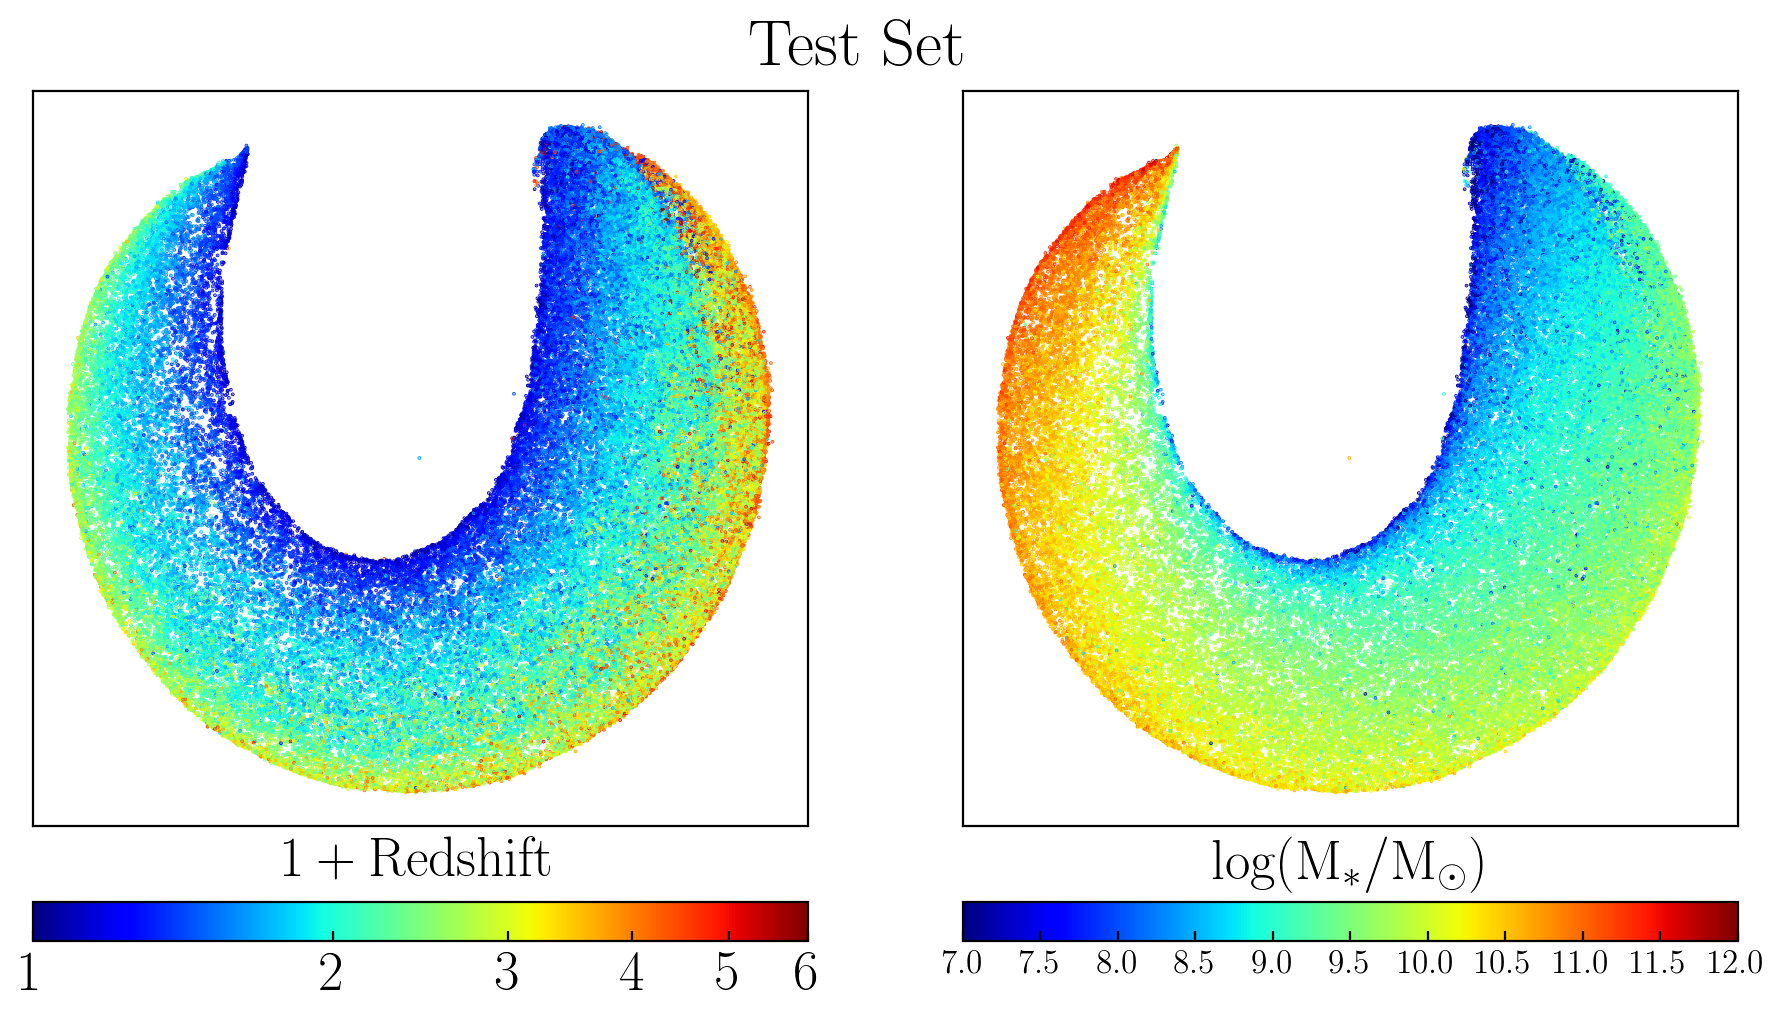

In [39]:
# Visualize the UMAP embedding for the test set
fig, ax = plt.subplots(1, 2, figsize=(11, 6))

props = dict(boxstyle='round', facecolor='white', alpha=0.3)

scatter_z = ax[0].scatter(
    *test_transform.T, s=0.1,
    c=1 + catalog_final_test['lp_zPDF'], cmap='jet',
    norm=LogNorm(vmin=1, vmax=6),
    rasterized=True
)
cbar_z = fig.colorbar(scatter_z, orientation="horizontal", pad=0.08, format='%.0f', ax=ax[0])
cbar_z.ax.xaxis.set_ticks(np.arange(1, 7))
ax[0].set_xlabel(r'$\rm 1+Redshift$', fontsize=20)
ax[0].invert_xaxis()
ax[0].invert_yaxis()
cbar_z.ax.tick_params(axis='y', direction='in',labelsize=23,length=5,width=1.1)
cbar_z.ax.tick_params(axis='x', direction='in')

scatter_mass = ax[1].scatter(
    *test_transform.T, s=0.1,
    c=catalog_final_test['lp_mass_med'], cmap='jet',
    vmin=7, vmax=12,
    rasterized=True
)
cbar_mass = fig.colorbar(scatter_mass, orientation="horizontal", pad=0.08, ax=ax[1])
cbar_mass.ax.xaxis.set_ticks(np.linspace(7, 12, num=11))
ax[1].set_xlabel(r'$\rm log(M_*/M_\odot)$', fontsize=20)
ax[1].invert_xaxis()
ax[1].invert_yaxis()
cbar_mass.ax.tick_params(axis='y', direction='in',labelsize=10,length=5,width=1.1)
cbar_mass.ax.tick_params(axis='x', direction='in',labelsize=12)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
fig.suptitle('Test Set')
fig.subplots_adjust(top=0.92)
# fig.savefig('Plots/umap_test.pdf', bbox_inches='tight')
plt.show()


The maps here can also be used to study the physical properties of galaxies although not the focus of this work. I will do it with Random forest.  Given the limited feature set (7), a Random Forest approach should be as effective as Neural Networks but simpler, requiring no data normalization.

#### Figure10: Flux Predictions

In [87]:
NIR_bands=['UVISTA_Y_FLUX', 'UVISTA_J_FLUX', 'UVISTA_H_FLUX']

# Prepare the data
X_train = catalog_final_train[H20_bands].values
y_train = catalog_final_train[NIR_bands].values

# Train the model
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

# Predictions
X_test = catalog_final_test[H20_bands].values
y_test = catalog_final_test[NIR_bands].values
predictions = regr.predict(X_test)

In [88]:
# Function to convert micro Jansky to AB magnitude
def uJy_to_AB(uJy):
    return -2.5 * np.log10(uJy / (10**6) / 3631)

def plot_band(band_label, pred, true, cmap='magma_r'):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

    ax = plt.subplot(gs[0])

    # Define major and minor ticks
    major_ticks = np.arange(15, 30, 1)
    minor_ticks = np.arange(15, 30, 0.5)

    # Set major and minor ticks for both axes
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    # Customize tick parameters
    ax.tick_params(which='major', direction='in', right='on', top='on', length=5, width=1, labelsize=10)
    ax.tick_params(which='minor', direction='in', right='on', top='on', length=2, width=0.3)

    # Mask out negative fluxes
    mask = (pred>0) & (true>0)
    pred = pred[mask]
    true = true[mask]
    
    # Convert fluxes to magnitudes and plot the histogram
    a = uJy_to_AB(pred)
    b = uJy_to_AB(true)
    
    nbins = 500
    H, xedges, yedges = np.histogram2d(a, b, bins=nbins)

    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value of zero

    im0 = ax.pcolor(xedges, yedges, np.log10(Hmasked), cmap='magma_r')

    # Plot the identity line
    ax.plot(np.linspace(15, 28, 1027), np.linspace(15, 28, 1027), linestyle='-', color='SpringGreen', linewidth=0.4)

    ax.set_xlim(17.5, 25.5)
    ax.set_ylim(17.5, 25.5)
    ax.set_ylabel(f'{band_label} AB mag (prediction from H20-like bands)', fontsize=10, labelpad=15)

    ax1 = plt.subplot(gs[1], sharex=ax)

    H, xedges, yedges = np.histogram2d(b, b-a, bins=nbins)

    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H == 0, H)

    im = ax1.pcolor(xedges, yedges, np.log10(Hmasked), cmap='magma_r')
    ax1.set_xlabel('Y AB mag (True)', fontsize=10)
    ax1.set_xlim(18.01, 25.5)

    ax1.set_yticks(np.arange(-1, 1, 0.5))
    ax1.set_yticks(np.arange(-1, 1, 0.25), minor=True)
    ax1.set_ylim(-0.5, 0.5)

    ax1.tick_params(which='major', direction='in', right='on', top='on', length=5, width=1, labelsize=10)
    ax1.tick_params(which='minor', direction='in', right='on', top='on', length=2, width=0.3)

    # Calculate and plot running median and its errors
    total_bins = 17
    bins = np.linspace(17.25, 25.5, total_bins)
    delta = bins[1] - bins[0]
    idx = np.digitize(b, bins)
    running_median = [np.median((b-a)[idx == k]) for k in range(2, total_bins - 1)]
    running_median_error_u = [np.percentile((b-a)[idx == k], 84) for k in range(2, total_bins - 1)]
    running_median_error_l = [np.percentile((b-a)[idx == k], 16) for k in range(2, total_bins - 1)]

    ax1.plot(bins[2:-1] - delta/2, running_median, c='SpringGreen', lw=1, alpha=.8)
    ax1.plot(bins[2:-1] - delta/2, running_median_error_u, c='SpringGreen', lw=1, alpha=.8, linestyle='--')
    ax1.plot(bins[2:-1] - delta/2, running_median_error_l, c='SpringGreen', lw=1, alpha=.8, linestyle='--')

    ax1.text(18.25, 0.25, f'$\Delta$={np.median(b-a):.4f}', fontsize=10)
    ax.text(18.3, 24.8, f'$\\rm 1\sigma\ scatter=$ {np.std(b-a):.2f} $\\rm mag$', fontsize=10)

    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0)

    # Set ylabel for the lower subplot
    ax1.set_ylabel(f'$\Delta${band_label} (AB)', fontsize=10)

    plt.show()



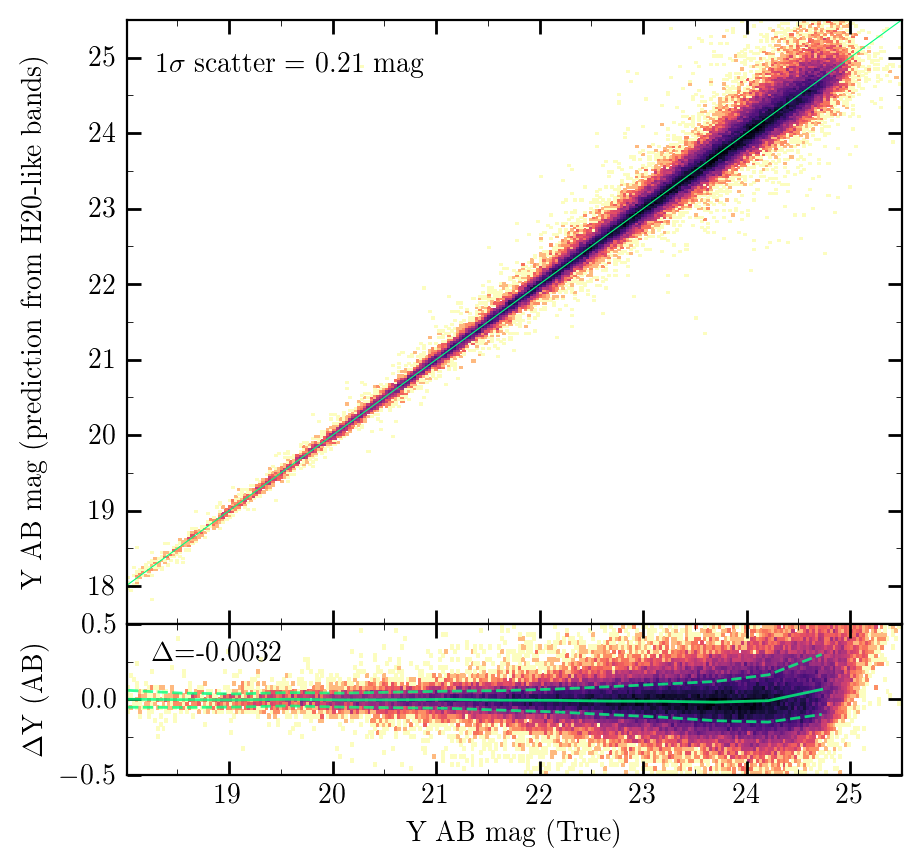

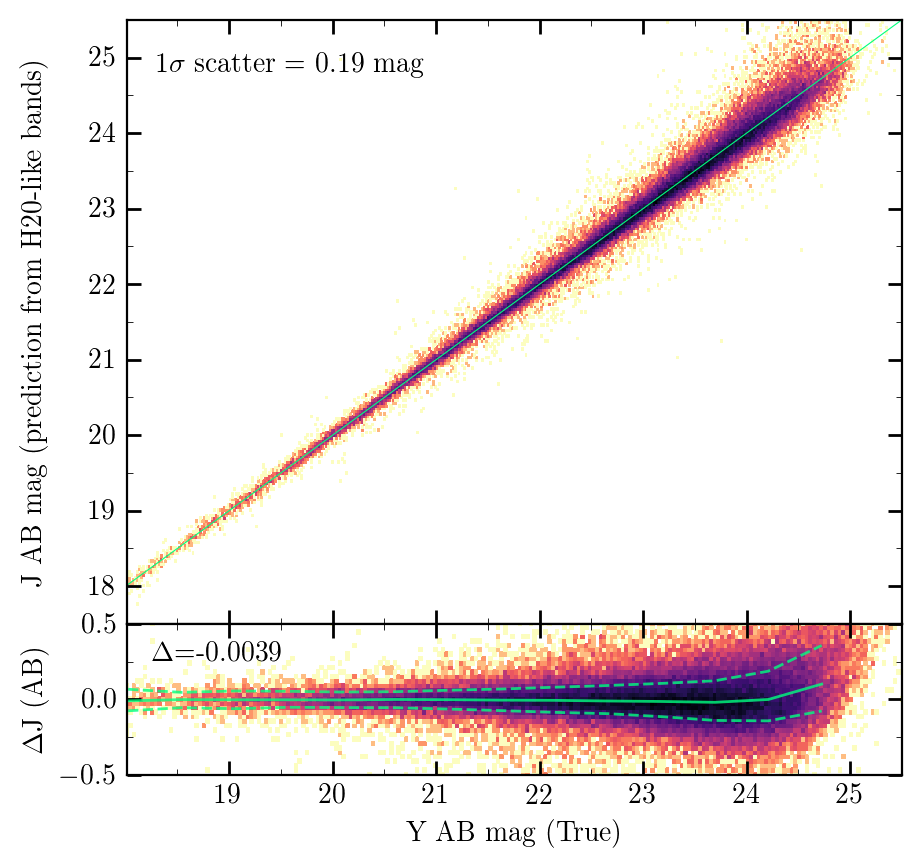

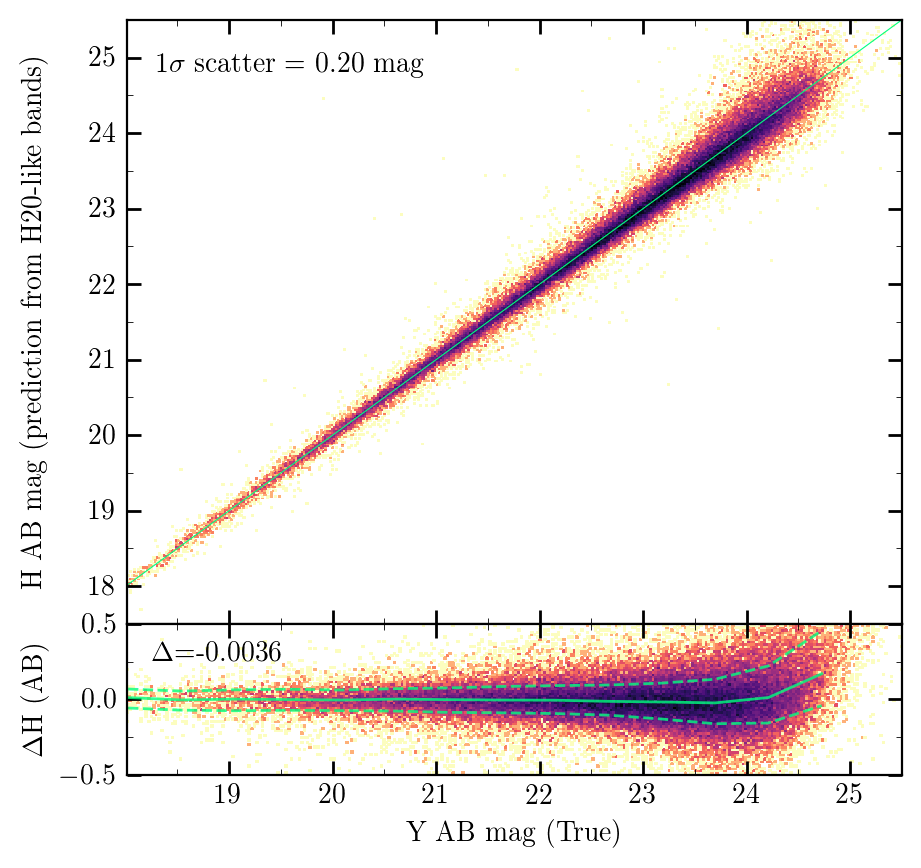

In [89]:
for i, label in enumerate(['Y', 'J', 'H']):
    plot_band(label, predictions[:, i], y_test[:, i])

#### Figure11: Photometric Redshift and Stellar Mass with ML model

In [118]:
# ML model with only h20 bands

    
def ML_model(bands,label,kind='redshift'):
    """
    Function to estimate photometric redshifts using a Machine Learning approach based on a RandomForestRegressor.
    
    Parameters:
        bands: List of photometric bands to use as features for the regression model.
        kind: redshift or mass
    
    Returns:
        This function does not return any value but generates a plot illustrating the comparison between the
        predicted and the actual values from the COSMOS2020 catalog.
    """
    # Prepare training data
    X_train = catalog_final_train[bands].values
    
    if kind=='redshift':
        y_train = catalog_final_train['lp_zPDF'].values
    elif kind=='mass':
        y_train = catalog_final_train['lp_mass_med'].values
    # Initialize and train the regression model
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)

    # Predict redshifts using the test data
    X_test = catalog_final_test[bands].values
    if kind=='redshift':
        y_test = catalog_final_test['lp_zPDF'].values
    elif kind=='mass':
        y_test = catalog_final_test['lp_mass_med'].values
    predicted_value = regressor.predict(X_test)

    if kind=='redshift':
        # Calculate normalized median absolute deviation of the prediction errors    
        normalized_median_absolute_deviation = 1.48 * np.median(np.abs(predicted_value.T - y_test.T) / (1 + y_test.T))
        # Calculate outlier fraction

        prediction_errors = np.abs(predicted_value.T - y_test.T) / (1 + y_test.T)
        outlier_fraction = np.mean(prediction_errors > 0.15)
    elif kind=='mass':
        normalized_median_absolute_deviation = 1.48 * np.median(np.abs(predicted_value.T - y_test.T))

        
    figure, axis = plt.subplots(figsize=(10, 6))

    major_ticks = np.arange(0, 13, 1)
    minor_ticks = np.arange(0, 13, 0.1)
    
    axis.set_xticks(major_ticks)
    axis.set_xticks(minor_ticks, minor=True)
    axis.set_yticks(major_ticks)
    axis.set_yticks(minor_ticks, minor=True)

    axis.tick_params(which='major', direction='in', right=True, top=True, length=6, width=1.3, labelsize=16)
    axis.tick_params(which='minor', direction='in', right=True, top=True, length=3, width=0.5)

    bins_count = 150
    histogram2d, xedges, yedges = np.histogram2d(y_test.T, predicted_value.T, bins=bins_count)

    histogram2d = np.rot90(histogram2d)
    histogram2d = np.flipud(histogram2d)

    histogram_masked = np.ma.masked_where(histogram2d == 0, histogram2d)

    im=axis.pcolor(xedges, yedges, np.log10(histogram_masked), cmap='magma_r')

    identity_line = np.linspace(0, 14, 10)
    axis.plot(identity_line, identity_line, linestyle='dashdot', color='black', markersize='1')

        
    color_bar = figure.colorbar(im, pad=0.02)
    color_bar.ax.yaxis.set_ticks([], minor=True)
    color_bar.ax.tick_params(axis='y', direction='in', labelsize=15, length=5, width=1.2)
    color_bar.ax.set_ylabel('$\log_{10}(\mathrm{Counts})$', fontsize=20)
    
    text_box_properties = dict(boxstyle='round', facecolor='white', alpha=0.3)

    # Annotate the plot with sigma and outlier fraction
    if kind=='redshift':
        axis.text(3.6, 0.6, f'$\\rm \\sigma^{{NMAD}}_{{\Delta z/(1+z)}}=$ {round(normalized_median_absolute_deviation, 3)}', fontsize=16)
        axis.text(3.74, 0.3, f'$\\rm OLF=$ {round(outlier_fraction * 100, 1)}'+'$\\%$', fontsize=16)
        axis.text(0.2, 4.5, label, fontsize=20, bbox=text_box_properties, color='black')

    elif kind=='mass':
        axis.text(3.8+6.5,0.6+6.2, f'$\\rm \\sigma^{{NMAD}}_{{\log(M_*/M_\odot)}}=$ {round(normalized_median_absolute_deviation, 3)}', fontsize=16)
        axis.text(0.2+6.5, 4.5+6.9, label, fontsize=20, bbox=text_box_properties, color='black')

    
    if kind=='redshift':
        axis.set_ylabel('Photometric redshift (Predicted)', fontsize=17)
        axis.set_xlabel('Photometric redshift (COSMOS2020)', fontsize=17)
        axis.set_ylim(0,5)
        axis.set_xlim(0,5)
    elif kind=='mass':
        axis.set_ylabel('$\\log(M_*/M_\odot)$ (Predicted)',fontsize=17)
        axis.set_xlabel('$\\log(M_*/M_\odot)$ (COSMOS2020)',fontsize=17)
        axis.set_ylim(6.5,12)
        axis.set_xlim(6.5,12)
    
    plt.show()


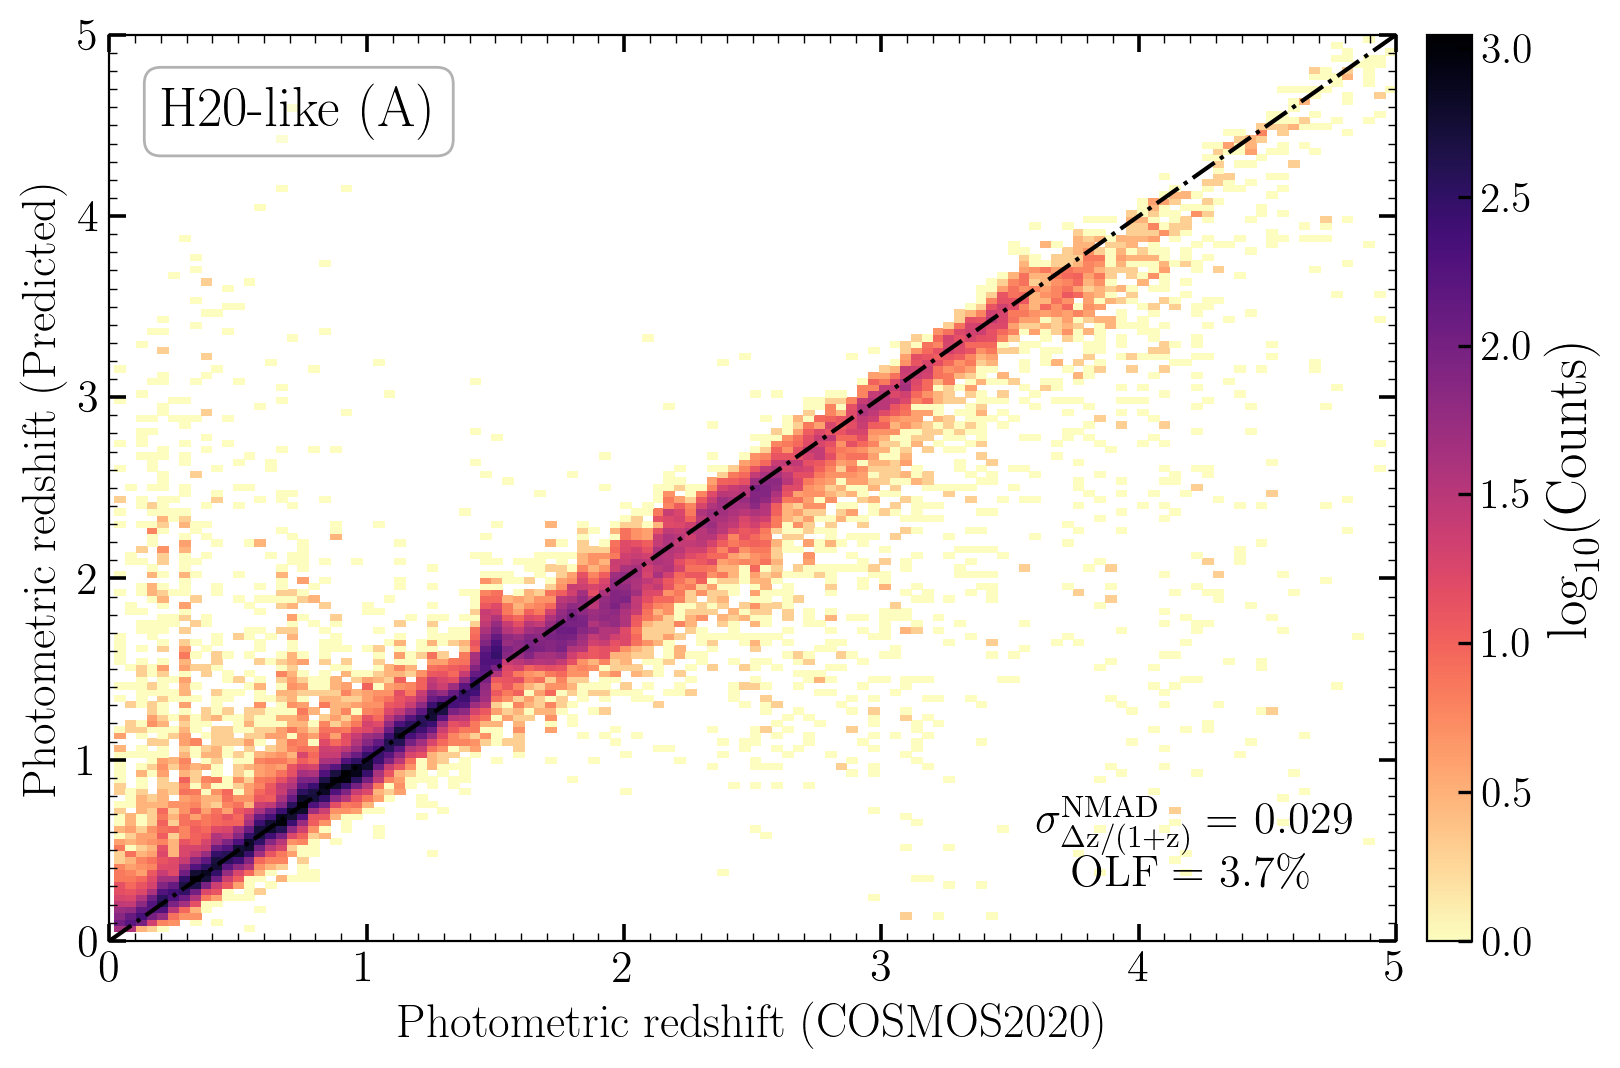

In [119]:
ML_model(H20_bands,label='H20-like (A)')

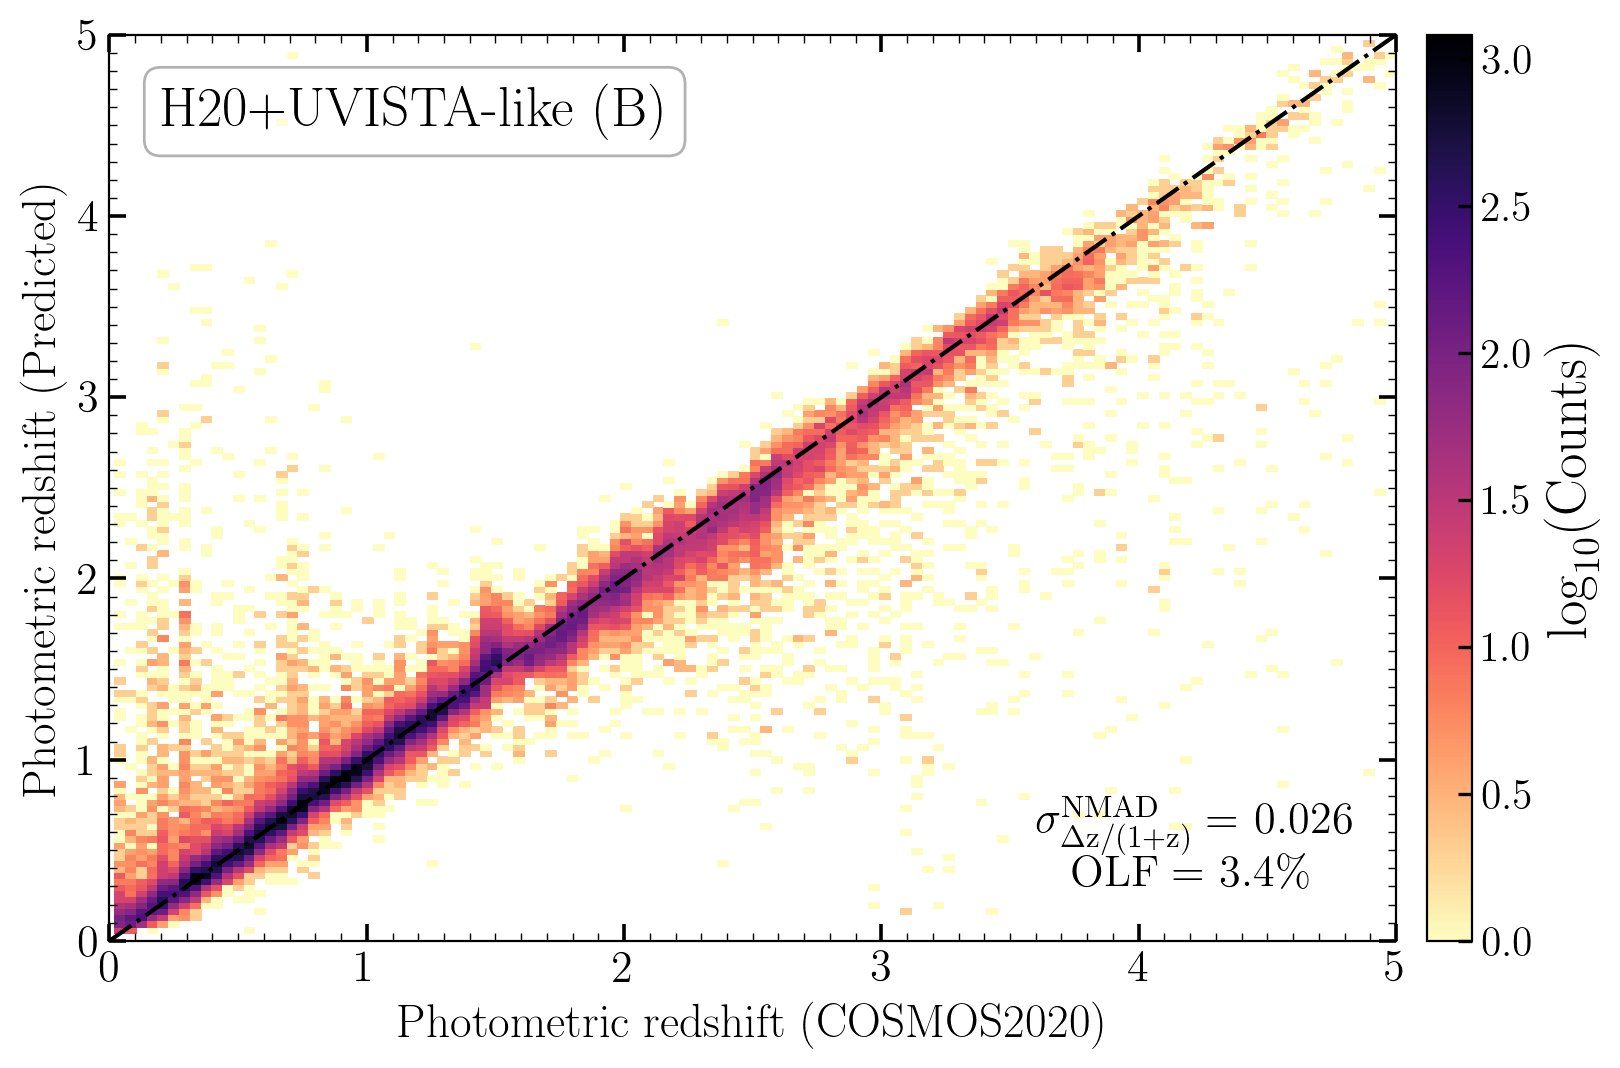

In [120]:
ML_model(selected_flux_columns,label='H20+UVISTA-like (B)')

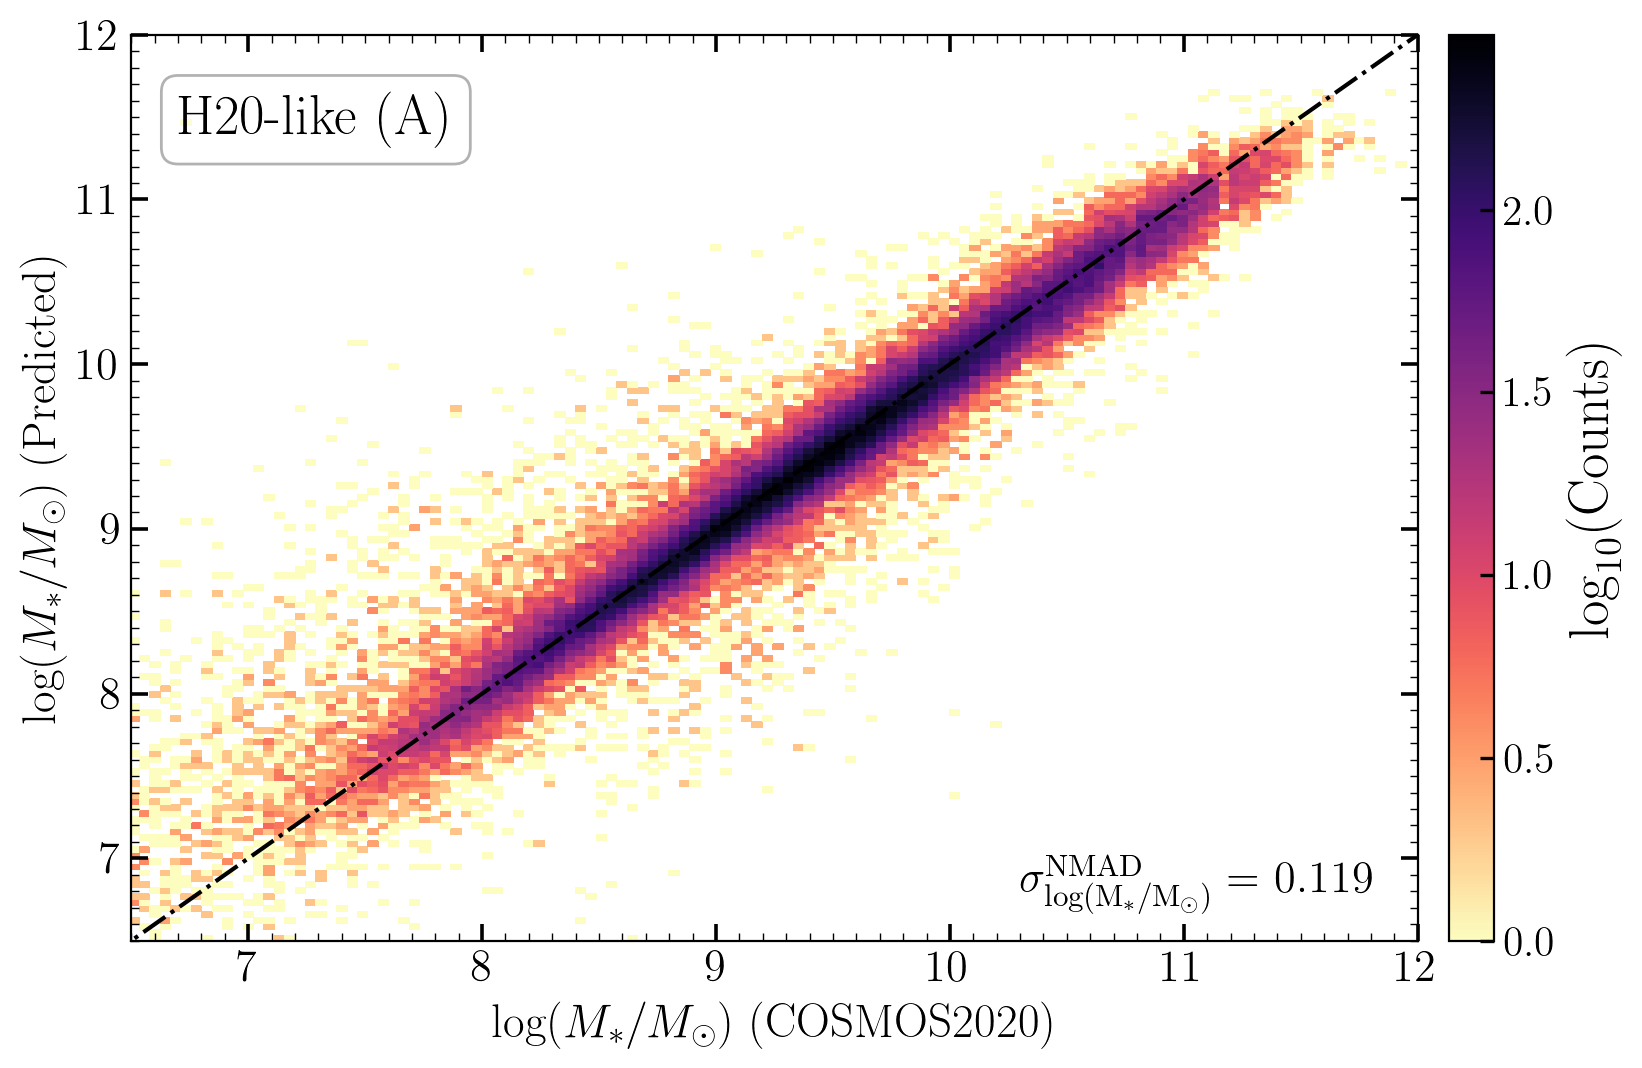

In [121]:
ML_model(H20_bands,label='H20-like (A)',kind='mass')

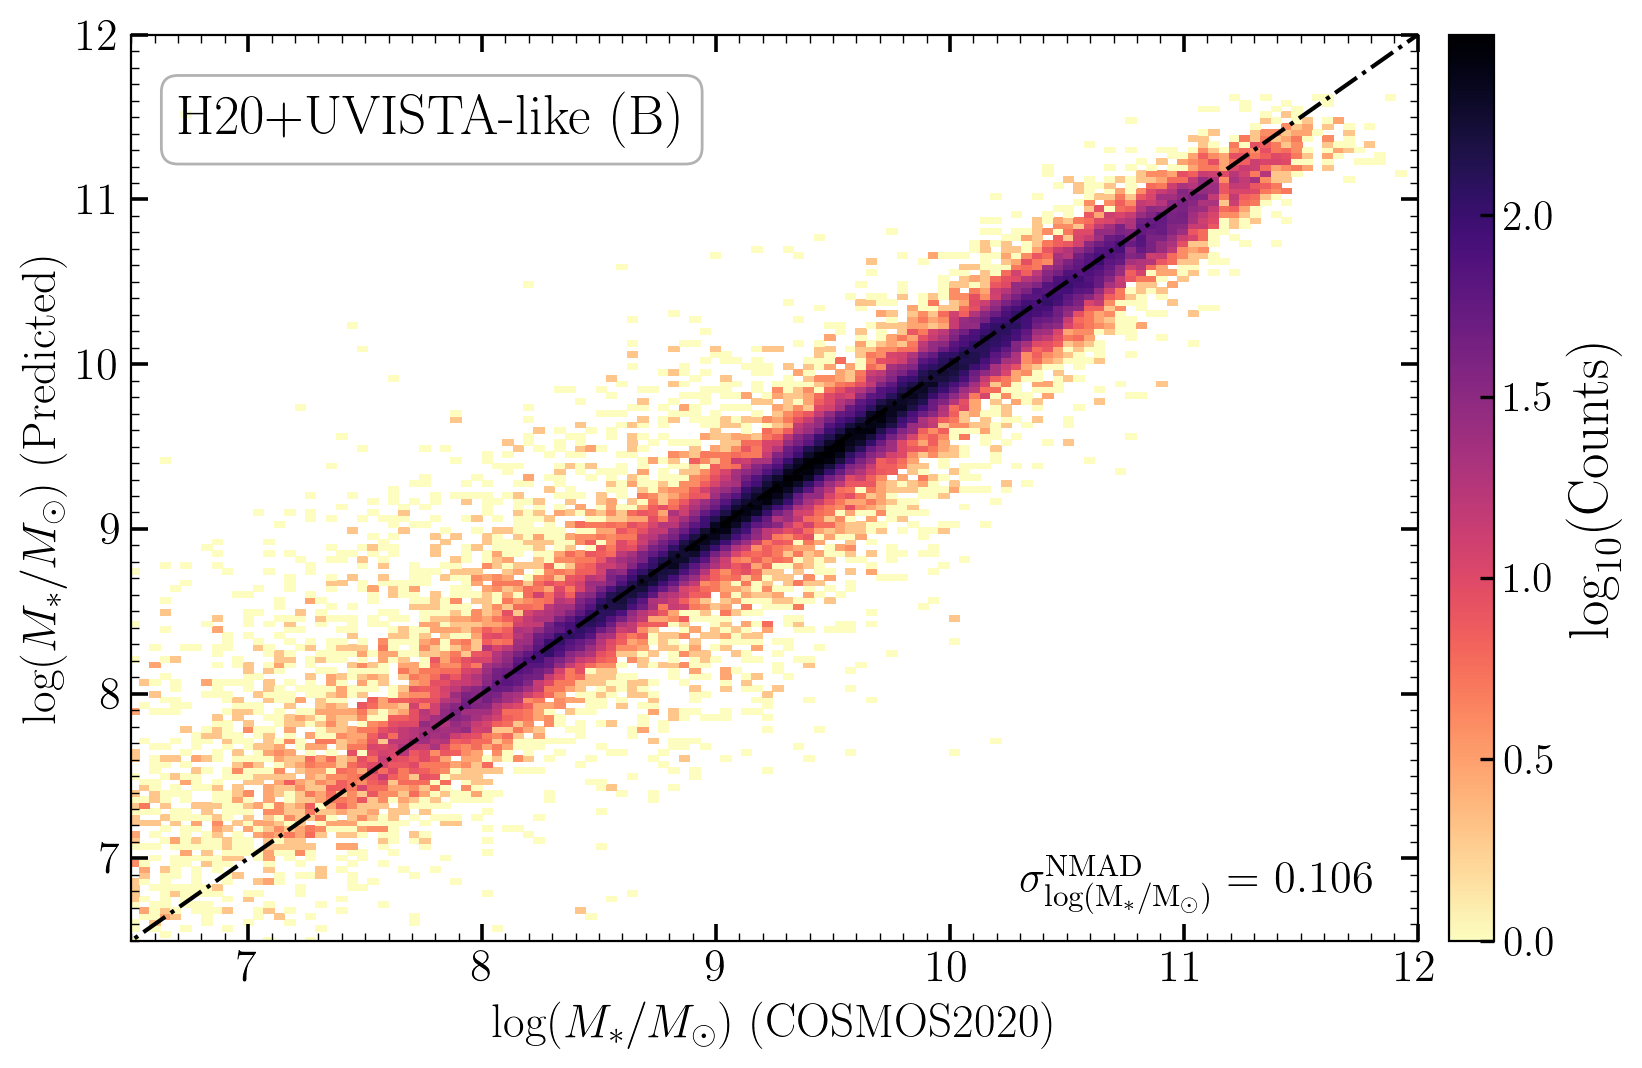

In [122]:
ML_model(selected_flux_columns,label='H20+UVISTA-like (B)',kind='mass')

#### Figure12: Incremental impact of additional wavebands on photometric redshift and stellar mass measurements

In [129]:
# Function to calculate sigma NMAD for redshift and mass
def calculate_sigma_nmad(bands,target='lp_zPDF'):

    X_train = catalog_final_train[bands]
    y_train = catalog_final_train[target]

    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)

    X_test = catalog_final_test[bands].values
    y_test = catalog_final_test[target].values
    predicted_value = regressor.predict(X_test)   
    
    if target=='lp_zPDF':
        sigma_nmad = 1.48 * np.median(np.abs(predicted_value - y_test) / (1 + y_test))
        return  sigma_nmad
    elif target=='lp_mass_med':
        sigma_nmad = 1.48 * np.median(np.abs(predicted_value - y_test))
        return sigma_nmad

In [130]:
# order of bands form information gain analysis
bands_order_redshift = [
    'HSC_i_FLUX',  'HSC_r_FLUX',  'CFHT_u_FLUX', 'IRAC_CH2_FLUX', 'HSC_z_FLUX', 'UVISTA_Y_FLUX',
     'UVISTA_J_FLUX', 'IRAC_CH1_FLUX', 'UVISTA_H_FLUX', 'HSC_g_FLUX'
]
bands_order_mass = [
    'HSC_i_FLUX', 'IRAC_CH2_FLUX', 'UVISTA_Y_FLUX', 'HSC_r_FLUX', 'CFHT_u_FLUX', 
    'IRAC_CH1_FLUX', 'UVISTA_J_FLUX', 'UVISTA_H_FLUX', 'HSC_z_FLUX', 'HSC_g_FLUX'
]

In [131]:
# Function to accumulate the bands and compute nmad
def accumulate_bands_and_compute(bands_order, target):
    nmads = []
    for i in range(1, len(bands_order) + 1):
        selected_bands = bands_order[:i]
        results = calculate_sigma_nmad(selected_bands,target)
        nmads.append(results)
    return nmads

In [132]:
nmads_z=accumulate_bands_and_compute(bands_order_redshift, 'lp_zPDF')

In [133]:
nmads_mass=accumulate_bands_and_compute(bands_order_mass, 'lp_mass_med')

(1.05, 0.009)

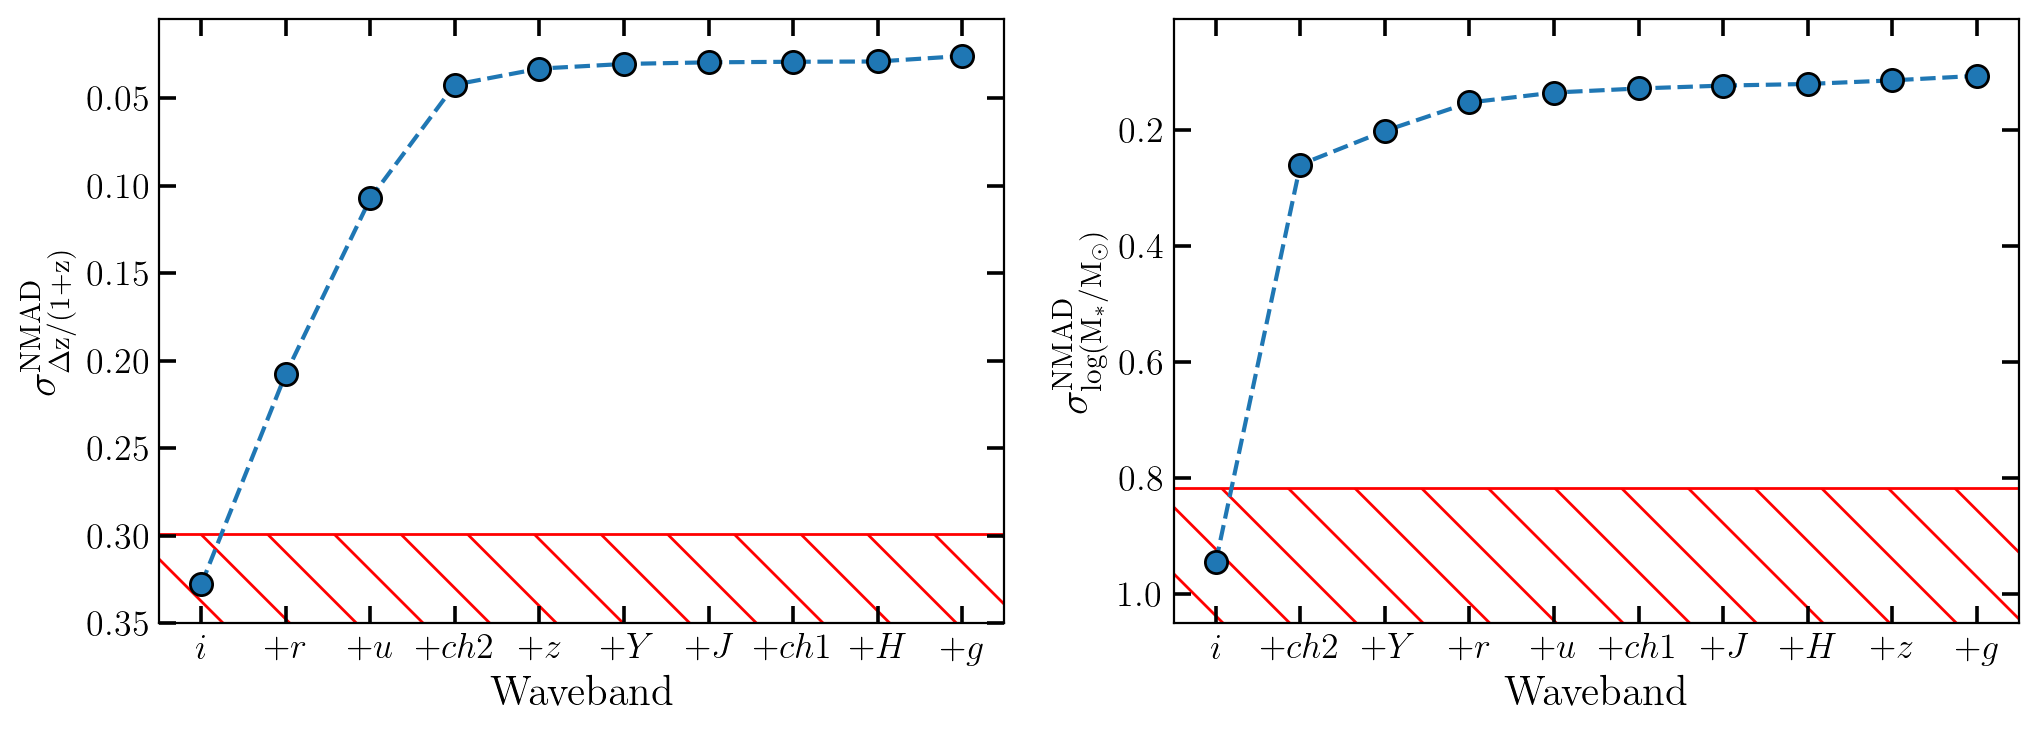

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

wavebands_first = ['$i$', '$+r$', '$+u$', '$+ch2$', '$+z$', '$+Y$', '$+J$', '$+ch1$', '$+H$', '$+g$']
wavebands_second = ['$i$', '$+ch2$', '$+Y$', '$+r$', '$+u$', '$+ch1$', '$+J$', '$+H$', '$+z$', '$+g$']

ax[0].plot(wavebands_first, nmads_z, marker='o', markeredgecolor='black', markersize=8, linestyle='--')
ax[0].tick_params(which='major', direction='in', right=True, top=True, length=6, width=1.3, labelsize=13)
ax[0].tick_params(which='minor', direction='in', right=True, top=True, length=3, width=0.5)
ax[0].set_ylabel(r'$\rm \sigma^{NMAD}_{\Delta z/(1+z)}$', fontsize=15)
ax[0].set_xlabel(r'$\rm{Waveband}$', fontsize=15)
ax[0].set_ylim(0.35,0.005)

sigma_redshift_intrinsic =1.48*np.median(np.absolute((catalog_final['lp_zPDF']-np.median(catalog_final['lp_zPDF']))/(1+np.median(catalog_final['lp_zPDF']))))
ax[0].fill_between([-2, 11], sigma_redshift_intrinsic, 0.35, hatch='\\', facecolor='None', edgecolor='r')
ax[0].set_xlim(-0.5, 9.5)

ax[1].plot(wavebands_second, nmads_mass, marker='o', markeredgecolor='black', markersize=8, linestyle='--')
ax[1].tick_params(which='major', direction='in', right=True, top=True, length=6, width=1.3, labelsize=13)
ax[1].tick_params(which='minor', direction='in', right=True, top=True, length=3, width=0.5)
ax[1].set_ylabel(r'$\rm \sigma^{NMAD}_{\log(M_*/M_\odot)}$', fontsize=15)
ax[1].set_xlabel(r'$\rm{Waveband}$', fontsize=15)
sigma_mass_intrinsic =1.48*np.median(np.absolute(catalog_final['lp_mass_med']-np.median(catalog_final['lp_mass_med'])))
ax[1].fill_between([-2, 11], sigma_mass_intrinsic , 1.5, hatch='\\', facecolor='None', edgecolor='r')
ax[1].set_xlim(-0.5, 9.5)
ax[1].set_ylim(1.05,0.009)

# plt.savefig('Plots/RF_bands.pdf', dpi=200, bbox_inches='tight')


#### Figure13: Visualizing synthetic photometric data used in SED fitting 

I built a set of theoretical templates using the 2016 version of a library of Bruzual & Charlot (2003), considering Chabrier (2003) IMF. Data from this simulations are in 'simulation.txt'.

In [156]:
simulated=np.loadtxt('simulation.txt')

In [157]:
theory_transform=mapper_h20.transform(simulated[1:-1:,0:7])

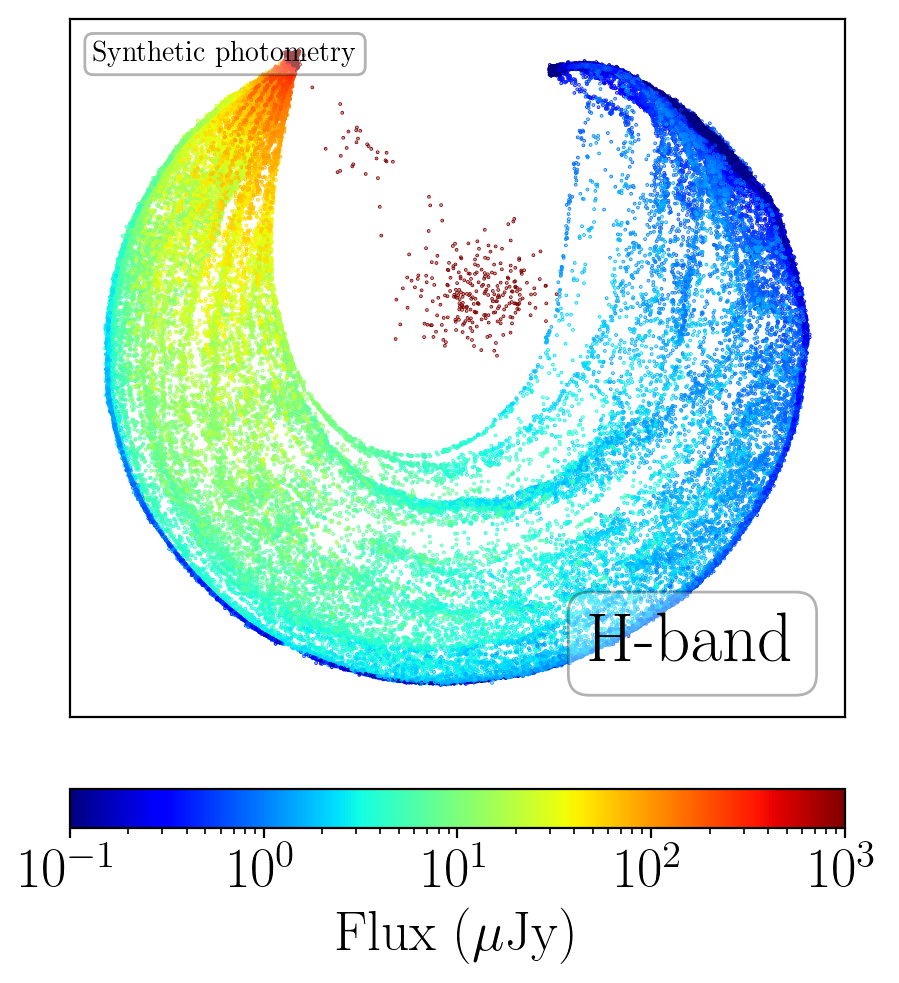

In [159]:
fig, ax = plt.subplots(figsize=(5, 6))

# Scatter plot for the UMAP embedding colored by the H-band flux
scatter = ax.scatter(
    *theory_transform.T,
    s=0.1,
    c=simulated[1:-1:,9],
    cmap='jet',
    norm=LogNorm(vmin=0.1, vmax=1000),
    rasterized=True
)

ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()
ax.invert_yaxis()

colorbar = fig.colorbar(scatter, orientation="horizontal", pad=0.08)
colorbar.ax.tick_params(axis='y', direction='in', labelsize=23, length=5, width=1.1)
colorbar.set_label('Flux ($\mu$Jy)', fontsize=20)

text_box_properties = dict(boxstyle='round', facecolor='white', alpha=0.3)
ax.text(0.67, 0.08, 'H-band', fontsize=25, bbox=text_box_properties, color='black', transform=ax.transAxes)
ax.text(0.03,0.94,'Synthetic photometry',fontsize=10, bbox=text_box_properties,color='black',transform = ax.transAxes)

plt.subplots_adjust(wspace=0, hspace=0)
# fig.savefig('Plots/umap_synthetic.pdf', bbox_inches='tight')

plt.show()


#### Figure14: SED fitting with predicted NIR bands

Results of SED fitting for three cases using 1) H20-like bands, 2) H20-like+predicted YHJ bands, and 3) H20 +UVISTA-like bands. I used the SED fitting code of LePhare 

In [142]:
data_no=pd.read_csv('Data/output_no.txt',delim_whitespace=True)
data_pre=pd.read_csv('Data/output_pre.txt',delim_whitespace=True)
data_tot=pd.read_csv('Data/output_tot.txt',delim_whitespace=True)

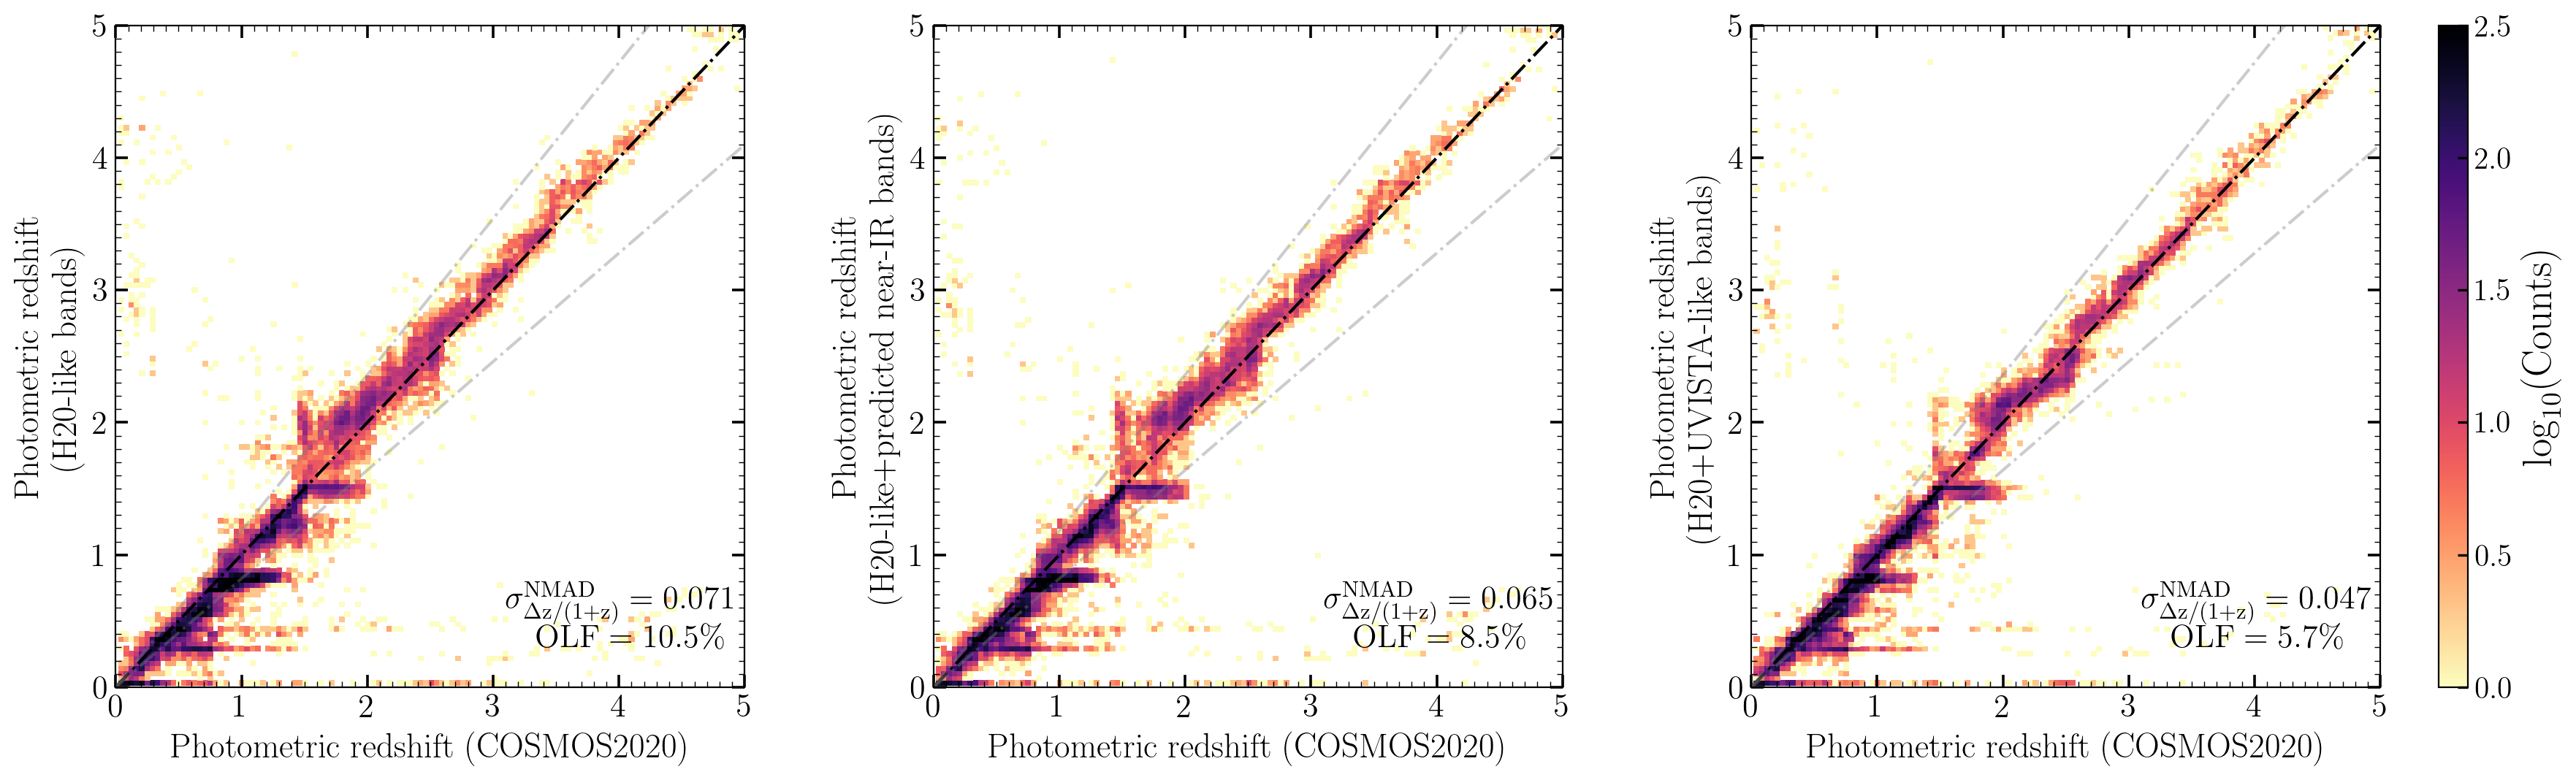

In [149]:
def calculate_metrics(data):
    a = data[data.Z_ML >= 0].lp_zPDF.values
    b = data[data.Z_ML >= 0].Z_ML.values
    sigma = 1.48 * np.median(np.abs(b - a) / (1 + a))
    err = np.abs(b - a) / (1 + a)
    olf = len(err[err > 0.15]) / len(err)
    return sigma, olf, a, b

def setup_axis(ax, xmajor, xminor, ymajor, yminor):
    ax.set_xticks(xmajor)
    ax.set_xticks(xminor, minor=True)
    ax.set_yticks(ymajor)
    ax.set_yticks(yminor, minor=True)
    ax.tick_params(which='major', direction='in', right='on', top='on', length=6, width=1.3, labelsize=16)
    ax.tick_params(which='minor', direction='in', right='on', top='on', length=3, width=0.5)

def plot_histogram(ax, a, b, nbins=150):
    H, xedges, yedges = np.histogram2d(a, b, bins=nbins)
    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value of zero
    return ax.pcolor(xedges, yedges, np.log10(Hmasked), cmap='magma_r', vmin=0, vmax=2.5)

# Define the common x and y ticks for the subplots.
xmajor = np.arange(0, 10, 1)
xminor = np.arange(0, 10, 0.1)
ymajor = np.arange(0, 10, 1)
yminor = np.arange(0, 10, 0.1)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

datasets = ['data_no', 'data_pre', 'data_tot']
y_labels = [
    'Photometric redshift\n (H20-like bands)',
    'Photometric redshift\n (H20-like+predicted near-IR bands)',
    'Photometric redshift\n (H20+UVISTA-like bands)'
]

for i, (dataset, ylabel) in enumerate(zip(datasets, y_labels)):
    data = catalog_final.merge(globals()[dataset], left_on='ID', right_on='IDENT')
    sigma, olf, a, b = calculate_metrics(data)
    setup_axis(ax[i], xmajor, xminor, ymajor, yminor)
    im = plot_histogram(ax[i], a, b)
    ax[i].plot([0, 5], [0, 5], linestyle='dashdot', color='black', markersize='1')
    ax[i].plot([0, 5], [0, 5.9], linestyle='dashdot', color='grey', markersize='1', alpha=0.4)
    ax[i].plot([0, 5], [0, 4.1], linestyle='dashdot', color='grey', markersize='1', alpha=0.4)
    ax[i].set_xlim(0, 5)
    ax[i].set_ylim(0, 5)
    ax[i].set_xlabel('Photometric redshift (COSMOS2020)', fontsize=17)
    ax[i].set_ylabel(ylabel, fontsize=17)
    ax[i].text(3.1, 0.6, f'$\\rm\\sigma^{{NMAD}}_{{\Delta z/(1+z)}}={round(sigma, 3)}$', fontsize=16)
    ax[i].text(3.34, 0.3, f'$\\rm OLF={round(olf * 100, 1)}\\%$', fontsize=16)

# Set up the colorbar.
cb_ax = fig.add_axes([0.92, 0.125, 0.01, 0.755])
cb=fig.colorbar(im,cax=cb_ax)
cb.ax.yaxis.set_ticks([], minor=True)
cb.ax.tick_params(axis='y', direction='in',labelsize=15,length=5,width=1.2)
cb.ax.set_ylabel('$\log_{10}(\mathrm{Counts})$',fontsize=20)
props = dict(boxstyle='round', facecolor='white', alpha=0.3)


plt.subplots_adjust(wspace=0.3, right=0.9)
plt.show()


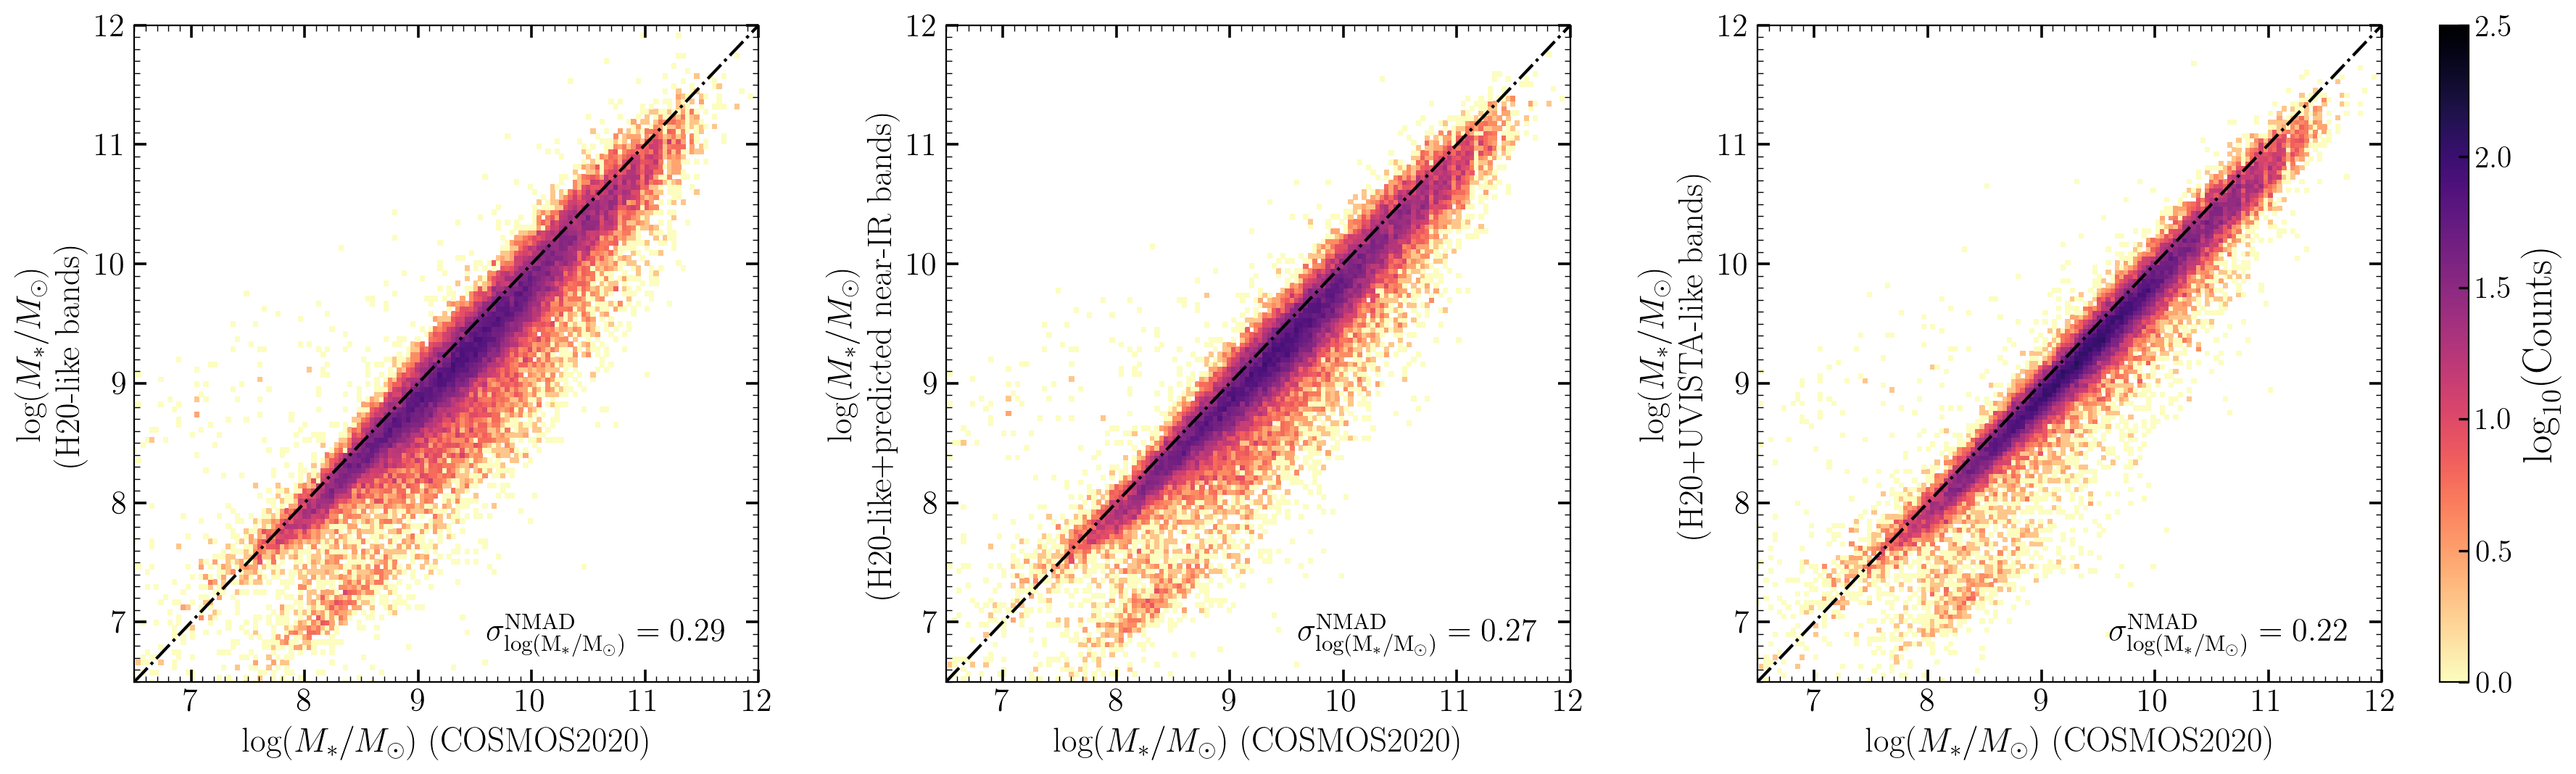

In [155]:
def calculate_metrics(data):
    a = data[(data.MASS_BEST>6) & (data.lp_mass_med>6)].lp_mass_med.values
    b = data[(data.MASS_BEST>6) & (data.lp_mass_med>6)].MASS_BEST.values
    sigma = 1.48 * np.median(np.abs(b - a))
    return sigma, a, b

def setup_axis(ax, xmajor, xminor, ymajor, yminor):
    ax.set_xticks(xmajor)
    ax.set_xticks(xminor, minor=True)
    ax.set_yticks(ymajor)
    ax.set_yticks(yminor, minor=True)
    ax.tick_params(which='major', direction='in', right='on', top='on', length=6, width=1.3, labelsize=16)
    ax.tick_params(which='minor', direction='in', right='on', top='on', length=3, width=0.5)

def plot_histogram(ax, a, b, nbins=150):
    H, xedges, yedges = np.histogram2d(a, b, bins=nbins)
    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value of zero
    return ax.pcolor(xedges, yedges, np.log10(Hmasked), cmap='magma_r', vmin=0, vmax=2.5)

# Define the common x and y ticks for the subplots.
xmajor = np.arange(0, 15, 1)
xminor = np.arange(0, 15, 0.1)
ymajor = np.arange(0, 15, 1)
yminor = np.arange(0, 15, 0.1)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

datasets = ['data_no', 'data_pre', 'data_tot']
y_labels = [
    '$\\log(M_*/M_\odot)$\n (H20-like bands)',
    '$\\log(M_*/M_\odot)$\n (H20-like+predicted near-IR bands)',
    '$\\log(M_*/M_\odot)$\n (H20+UVISTA-like bands)'
]

for i, (dataset, ylabel) in enumerate(zip(datasets, y_labels)):
    data = catalog_final.merge(globals()[dataset], left_on='ID', right_on='IDENT')
    sigma, a, b = calculate_metrics(data)
    setup_axis(ax[i], xmajor, xminor, ymajor, yminor)
    im = plot_histogram(ax[i], a, b)
    ax[i].plot([5, 15], [5, 15], linestyle='dashdot', color='black', markersize='1')
    ax[i].set_xlim(6.5, 12)
    ax[i].set_ylim(6.5, 12)
    ax[i].set_xlabel('$\\log(M_*/M_\odot)$ (COSMOS2020)', fontsize=17)
    ax[i].set_ylabel(ylabel, fontsize=17)
    ax[i].text(3.2+6.4,0.65+6.2, f'$\\rm\\sigma^{{NMAD}}_{{\log(M_*/M_\odot)}}={round(sigma, 2)}$', fontsize=16)

# Set up the colorbar.
cb_ax = fig.add_axes([0.92, 0.125, 0.01, 0.755])
cb=fig.colorbar(im,cax=cb_ax)
cb.ax.yaxis.set_ticks([], minor=True)
cb.ax.tick_params(axis='y', direction='in',labelsize=15,length=5,width=1.2)
cb.ax.set_ylabel('$\log_{10}(\mathrm{Counts})$',fontsize=20)
props = dict(boxstyle='round', facecolor='white', alpha=0.3)


plt.subplots_adjust(wspace=0.3, right=0.9)
plt.show()
